# Safety Recommenders Project:

# Project Description

The objective of the project is create a data product that helps people that are traveling to Washington DC to determine how safe are the most popular places in the city.

## Dataset Description

This Project one dataset. The  dataset is a csv file that contains all the crimes that have occurred in the past 8 years around Washington DC.
In order to improve the model, new features will be added to the dataset, mainly weather data.

Finally, after the first analyses, some of the features of the crime dataset will be removed to make the data product simpler to use. Features like date, time, location and address will be kept, and features like offense type and location codes used by the police department will also be removed.


### Importing Main Libraries:

In [80]:
%matplotlib notebook
import IPython
from IPython.display import display
from sqlalchemy import create_engine
import psycopg2
import psycopg2.extras
import pandas as pd
import csv
from numpy import nan as NA
from datetime import datetime
import re
import sys
import numpy as np
import matplotlib.pyplot as plt 
import scipy as sp
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from pandas import *
import pickle
import requests
import os
from sklearn.preprocessing import LabelEncoder

# ------------------------DATA INGESTION------------------------

First of all, we will change pandas settings so it can show all the features 

In [81]:
#Panda settings
#Pandas will not display all columns in our data when using the head() function without this
pd.set_option('max_columns',50) 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

Here We are creating the module that will take care of our csv file. One class is designed to deal with csv files and the other class to deal with a postgres database:

In [82]:
class Ingestion(object):
    """This is the ingestion class to deal with csv directly from the same directory where the module is"""

    def __init__(self, file, sep = ",", header = 0 ):
        self.file = file
        self.delimiter = sep
        self.df = pd.read_csv(file, sep= sep, header=header, engine='python', 
                              parse_dates = False)

    def file_csv(self):
        return self.df

class IngestionDatabase(object):

    """ This is the ingestion class to deal with postgress database """
    def __init__(self, database, query):
        self.engine = create_engine(database)
        self.table_names = self.engine.table_names()
        self.con = self.engine.connect()
        self.rs = self.con.execute(query)
        self.df = pd.DataFrame(self.rs.fetchmany(size=15))

    def cols(self):
        self.df.columns = self.rs.keys()
        return self.df

class OnlineFetch(object):
    
    def __init__(self, URL, fname="dc-crimes-search-results.csv"):
        self.URL = URL
        self.fname = fname 
        
  
    def fetch_data(self):
        """
        Helper method to retrieve the ML Repository dataset.
        """
        self.response = requests.get(self.URL)
        self.outpath  = os.path.abspath(self.fname)
        
        with open(self.outpath, 'wb') as f:
            f.write(self.response.content)
            return self.outpath

## Creating the Ingestion instances for the crime dataset and weather dataset:

In [83]:
ingest = Ingestion('DC_Crime_Official2.csv')
data = ingest.file_csv()

In [84]:
ingest = Ingestion('dc_weather_2010-2018.csv')
weather_data = ingest.file_csv()

In [85]:
data.head(5)

,NEIGHBORHOOD_CLUSTER,CENSUS_TRACT,offensegroup,LONGITUDE,END_DATE,offense-text,SHIFT,YBLOCK,DISTRICT,WARD,YEAR,offensekey,BID,sector,PSA,ucr-rank,BLOCK_GROUP,VOTING_PRECINCT,XBLOCK,BLOCK,START_DATE,CCN,OFFENSE,ANC,REPORT_DAT,METHOD,location,LATITUDE
0,cluster 15,600.0,property,-77.069766,2015-05-05T17:45:00.000,theft f/auto,evening,140519.000000,2.0,3.0,2015,property|theft f/auto,NaN,2D2,204.0,7,000600 3,precinct 27,393951.000000,3500 - 3599 block of lowell street nw,2015-05-05T15:00:00.000,15064669,theft f/auto,3C,2015-05-05T22:06:00.000Z,others,"38.932540365033717,-77.069768169731375",38.932533
1,cluster 2,3000.0,violent,-77.031208,2015-05-05T20:55:00.000,robbery,evening,140084.000000,3.0,1.0,2015,violent|robbery,NaN,3D1,302.0,4,003000 2,precinct 39,397294.000000,1300 - 1399 block of irving street nw,2015-05-05T20:50:00.000,15064781,robbery,1A,2015-05-06T01:05:00.000Z,gun,"38.928638407177509,-77.031210110921407",38.928631
2,cluster 3,4400.0,property,-77.028460,2015-05-05T22:14:00.000,motor vehicle theft,evening,139201.000000,3.0,1.0,2015,property|motor vehicle theft,NaN,3D2,305.0,8,004400 1,precinct 22,397532.000000,1200 - 1247 block of florida avenue nw,2015-05-05T18:18:00.000,15064796,motor vehicle theft,1B,2015-05-06T02:58:00.000Z,others,"38.920684762113531,-77.028462123394547",38.920677
3,cluster 23,8804.0,violent,-76.985496,2015-06-23T08:00:00.000,homicide,midnight,137689.000000,5.0,5.0,2015,violent|homicide,NaN,5D3,506.0,1,008804 1,precinct 78,401258.000000,1200 - 1299 block of holbrook terrace ne,2015-06-23T05:23:00.000,15094190,homicide,5D,2015-06-24T04:00:00.000Z,gun,"38.907066722563066,-76.985498377563218",38.907059
4,cluster 25,8100.0,property,-76.990245,2015-06-23T06:30:00.000,theft f/auto,day,136398.650012,1.0,6.0,2015,property|theft f/auto,NaN,1D2,107.0,7,008100 1,precinct 81,400846.210015,duncan place ne and 12th street ne,2015-06-22T22:00:00.000,15094194,theft f/auto,6A,2015-06-23T12:48:00.000Z,others,"38.895443280295112,-76.990247632314322",38.895435


In [86]:
weather_data.head(5)

,Year,Month,Day,Hour,Temperature,Precipitation,Snowfall
0,2010,1,1,0,44.92,0.0,0.0
1,2010,1,1,1,43.83,0.0,0.0
2,2010,1,1,2,42.22,0.0,0.0
3,2010,1,1,3,40.23,0.0,0.0
4,2010,1,1,4,39.38,0.0,0.0


# -------------------------DATA WRANGLING--------------------

1. Wrangling crime data:

In [87]:
class Wrangling(object):

    def __init__(self, data = data):
        self.df = data
# drop empty rows
    def dropNA(self):
        self.df = self.df.dropna(how='all') # this only drop rows with 100% NA
        return self.df

    def __offense_column(self, text1 ='theft/other', text2 ='theft f/auto', text3 = 'assault w/dangerous weapon',
                       repl1 = 'theft', repl2 = 'auto theft', repl3 = 'assault with weapon' ):

        """There are 9 categories of offenses here:
        This function will transform the caterogies into more readable text
        for example : assault w/dangerous weapon = assault with dangerous weapon"""

        self.df['offense_text'] = self.df['offense_text'].replace([text1, text2, # add the column name to the arguments.
        text3], [repl1, repl2, repl3])
        return self.df

    def date_time_transformer(self, time = 'START_DATE', second_date = 'REPORT_DAT', third_date = 'END_DATE'):
        ''' transform into datetime 64 object and eliminate the second date column'''
        self.df[second_date] = pd.to_datetime(self.df['REPORT_DAT'])
        self.df.drop([time, third_date], axis = 1, inplace = True)
        return self.df

    def __latlong_cutter(self):
        """ Reduce the presition of the lat long data by cutting them."""
        self.newlat = []
        self.newlon = []
        for item in self.df['LATITUDE']:
            item = str(item)
            item = float(item[0:6])
            self.newlat.append(item)

        self.df['LATITUDE'] = self.newlat

        for item in self.df['LONGITUDE']:
            item = str(item)
            item = float(item[0:7])
            self.newlon.append(item)
        self.df['LONGITUDE'] = self.newlon

        return self.df

    def lat_long_rounder(self, decimals = 3):
        """ Reduce the presition of the lat long data by rounging decimals"""
        self.df['LATITUDE'] = self.df['LATITUDE'].round(decimals = decimals)
        self.df['LONGITUDE'] = self.df['LONGITUDE'].round(decimals = decimals)
        return self.df

    def adress_format_modifier(self):
        """This columns replace some of the content from the block columns to it is easy to parse it"""

        self.splitted = []

        # creating the splited column
        # this is working. it cannot be transformed into pandas' .replace because it is using the split method
        # Note that the built in .replace it does not work properly with integers and neither with large amounts of
        # things to change.. This works but it is not very wise to use.
        for row in self.df['BLOCK']:
            row = row.replace("block of ", "")
            row = row.replace("street", "St")
            row = row.replace("-", "")
            row = row.split(' ', 1)
            self.splitted.append(row)
        self.df['splitted'] = self.splitted
        return self.df

    def block_parser(self):
        """ This is the block parser that separate block in start and en blocks"""

        self.startblock = []
        self.endblock_1 = []
        self.endblock = []
        #  create column 'startblock'
        for row in self.df['splitted']:
            row = row[0]
            self.startblock.append(row)
        self.df['startblock'] = self.startblock
        # create column  'endblock_1'
        for row in self.df['splitted']:
            row = row[-1].lstrip() # enblock_1
            row = row.split(' ',1)
            self.endblock_1.append(row)
        self.df['endblock_1'] = self.endblock_1
        # create column  'endblock'
        for row in self.df['endblock_1']:
            row = row[0]
            self.endblock.append(row)
        self.df['endblock'] = self.endblock
        return self.df

    def street_parser(self):
        self.street = []
        #creating column 'street'
        for row in self.df['endblock_1']:
            row = row[1]
            self.street.append(row)
        self.df['street'] = self.street
        return self.df

In [88]:
Wrangled = Wrangling()
Wrangled.dropNA()
Wrangled.date_time_transformer()
Wrangled.lat_long_rounder()
Wrangled.adress_format_modifier()
Wrangled.block_parser()
crime_df = Wrangled.street_parser()

In [89]:
crime_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 282475 entries, 0 to 282474
Data columns (total 31 columns):
NEIGHBORHOOD_CLUSTER    278891 non-null object
CENSUS_TRACT            281632 non-null float64
offensegroup            282475 non-null object
LONGITUDE               282475 non-null float64
offense-text            282475 non-null object
SHIFT                   282475 non-null object
YBLOCK                  282475 non-null float64
DISTRICT                282313 non-null float64
WARD                    282463 non-null float64
YEAR                    282475 non-null int64
offensekey              282475 non-null object
BID                     46124 non-null object
sector                  282296 non-null object
PSA                     282296 non-null float64
ucr-rank                282475 non-null int64
BLOCK_GROUP             281632 non-null object
VOTING_PRECINCT         282414 non-null object
XBLOCK                  282475 non-null float64
BLOCK                   282475 non-null

In [90]:
crime_df["REPORT_DAT"] = pd.to_datetime(crime_df["REPORT_DAT"])

    1.1: Set the REPORT_DAT column from the crime dataset as an index:

In [91]:
crime_df = crime_df.rename(columns = {'REPORT_DAT': 'datetime'})

In [92]:

crime_df["year"] =crime_df["datetime"].dt.year
crime_df["month"] =crime_df["datetime"].dt.month
crime_df["day"] =crime_df["datetime"].dt.day
crime_df["hour"] =crime_df["datetime"].dt.hour
crime_df["minute"] =crime_df["datetime"].dt.minute
crime_df["second"] =crime_df["datetime"].dt.second

        1.1.1 The maximum precision of the weather dataset is hourly, so we need to change the format:

In [93]:
crime_df['datetime'] = crime_df['datetime'].apply(lambda x: x.replace(minute = 0, second = 0))

        1.1.2: Adding index to crime dataset:

In [94]:
crime_df = crime_df.set_index(pd.DatetimeIndex(crime_df['datetime']), drop = False)

In [95]:
crime_df.head()

,NEIGHBORHOOD_CLUSTER,CENSUS_TRACT,offensegroup,LONGITUDE,offense-text,SHIFT,YBLOCK,DISTRICT,WARD,YEAR,offensekey,BID,sector,PSA,ucr-rank,BLOCK_GROUP,VOTING_PRECINCT,XBLOCK,BLOCK,CCN,OFFENSE,ANC,datetime,METHOD,location,LATITUDE,splitted,startblock,endblock_1,endblock,street,year,month,day,hour,minute,second
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-05-05 22:00:00,cluster 15,600.0,property,-77.070,theft f/auto,evening,140519.000000,2.0,3.0,2015,property|theft f/auto,NaN,2D2,204.0,7,000600 3,precinct 27,393951.000000,3500 - 3599 block of lowell street nw,15064669,theft f/auto,3C,2015-05-05 22:00:00,others,"38.932540365033717,-77.069768169731375",38.933,"[3500, 3599 lowell St nw]",3500,"[3599, lowell St nw]",3599,lowell St nw,2015,5,5,22,6,0
2015-05-06 01:00:00,cluster 2,3000.0,violent,-77.031,robbery,evening,140084.000000,3.0,1.0,2015,violent|robbery,NaN,3D1,302.0,4,003000 2,precinct 39,397294.000000,1300 - 1399 block of irving street nw,15064781,robbery,1A,2015-05-06 01:00:00,gun,"38.928638407177509,-77.031210110921407",38.929,"[1300, 1399 irving St nw]",1300,"[1399, irving St nw]",1399,irving St nw,2015,5,6,1,5,0
2015-05-06 02:00:00,cluster 3,4400.0,property,-77.028,motor vehicle theft,evening,139201.000000,3.0,1.0,2015,property|motor vehicle theft,NaN,3D2,305.0,8,004400 1,precinct 22,397532.000000,1200 - 1247 block of florida avenue nw,15064796,motor vehicle theft,1B,2015-05-06 02:00:00,others,"38.920684762113531,-77.028462123394547",38.921,"[1200, 1247 florida avenue nw]",1200,"[1247, florida avenue nw]",1247,florida avenue nw,2015,5,6,2,58,0
2015-06-24 04:00:00,cluster 23,8804.0,violent,-76.985,homicide,midnight,137689.000000,5.0,5.0,2015,violent|homicide,NaN,5D3,506.0,1,008804 1,precinct 78,401258.000000,1200 - 1299 block of holbrook terrace ne,15094190,homicide,5D,2015-06-24 04:00:00,gun,"38.907066722563066,-76.985498377563218",38.907,"[1200, 1299 holbrook terrace ne]",1200,"[1299, holbrook terrace ne]",1299,holbrook terrace ne,2015,6,24,4,0,0
2015-06-23 12:00:00,cluster 25,8100.0,property,-76.990,theft f/auto,day,136398.650012,1.0,6.0,2015,property|theft f/auto,NaN,1D2,107.0,7,008100 1,precinct 81,400846.210015,duncan place ne and 12th street ne,15094194,theft f/auto,6A,2015-06-23 12:00:00,others,"38.895443280295112,-76.990247632314322",38.895,"[duncan, place ne and 12th St ne]",duncan,"[place, ne and 12th St ne]",place,ne and 12th St ne,2015,6,23,12,48,0


2. Wrangling weather data:

In [96]:
weather_data['datetime'] =  pd.to_datetime(weather_data[['Year', 'Month', 'Day', 'Hour']])

In [97]:
weather_data.head(5)

,Year,Month,Day,Hour,Temperature,Precipitation,Snowfall,datetime
0,2010,1,1,0,44.92,0.0,0.0,2010-01-01 00:00:00
1,2010,1,1,1,43.83,0.0,0.0,2010-01-01 01:00:00
2,2010,1,1,2,42.22,0.0,0.0,2010-01-01 02:00:00
3,2010,1,1,3,40.23,0.0,0.0,2010-01-01 03:00:00
4,2010,1,1,4,39.38,0.0,0.0,2010-01-01 04:00:00


    2.1 Seting index for weather data:

In [98]:
weather_data = weather_data.set_index(pd.DatetimeIndex(weather_data['datetime']), drop = False)

In [99]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 74064 entries, 2010-01-01 00:00:00 to 2018-06-13 23:00:00
Data columns (total 8 columns):
Year             74064 non-null int64
Month            74064 non-null int64
Day              74064 non-null int64
Hour             74064 non-null int64
Temperature      74064 non-null float64
Precipitation    74064 non-null float64
Snowfall         74064 non-null float64
datetime         74064 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(4)
memory usage: 5.1 MB


In [100]:
weather_data.head(5)

,Year,Month,Day,Hour,Temperature,Precipitation,Snowfall,datetime
datetime,,,,,,,,
2010-01-01 00:00:00,2010,1,1,0,44.92,0.0,0.0,2010-01-01 00:00:00
2010-01-01 01:00:00,2010,1,1,1,43.83,0.0,0.0,2010-01-01 01:00:00
2010-01-01 02:00:00,2010,1,1,2,42.22,0.0,0.0,2010-01-01 02:00:00
2010-01-01 03:00:00,2010,1,1,3,40.23,0.0,0.0,2010-01-01 03:00:00
2010-01-01 04:00:00,2010,1,1,4,39.38,0.0,0.0,2010-01-01 04:00:00


3. Merging the datasets:

First, we need to eliminate duplicate values and select the time range of the second dataset. this is to prevent the left join to generate extra values

In [101]:
a= weather_data.index.duplicated(keep = False)
a = DataFrame(a)
b = a[a[0]== True]
b.count()

0    0
dtype: int64

3.1 Setting up the time range:

In [102]:
crime_df['datetime'].min()

Timestamp('2010-06-11 04:00:00')

In [103]:
crime_df['datetime'].max()

Timestamp('2018-06-11 03:00:00')

In [104]:
crime_df = crime_df.sort_values('datetime')
weather_data = weather_data.sort_values('datetime')

/home/franco/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 'datetime' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  """Entry point for launching an IPython kernel.
/home/franco/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 'datetime' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  


3.1.1 Setting up the time range so it matches the crime data (the weather dataset contains dates that do not exist in the weather dataset:

In [105]:
idx = pd.date_range('2010-06-11 04:00:00', '2018-06-11 03:00:00', freq = "H")

In [106]:
crime_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 282475 entries, 2010-06-11 04:00:00 to 2018-06-11 03:00:00
Data columns (total 37 columns):
NEIGHBORHOOD_CLUSTER    278891 non-null object
CENSUS_TRACT            281632 non-null float64
offensegroup            282475 non-null object
LONGITUDE               282475 non-null float64
offense-text            282475 non-null object
SHIFT                   282475 non-null object
YBLOCK                  282475 non-null float64
DISTRICT                282313 non-null float64
WARD                    282463 non-null float64
YEAR                    282475 non-null int64
offensekey              282475 non-null object
BID                     46124 non-null object
sector                  282296 non-null object
PSA                     282296 non-null float64
ucr-rank                282475 non-null int64
BLOCK_GROUP             281632 non-null object
VOTING_PRECINCT         282414 non-null object
XBLOCK                  282475 non-null float64
BLOCK

In [107]:
df = pd.merge(crime_df, weather_data, how='left', on='datetime', left_index= True)

/home/franco/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: FutureWarning: 'datetime' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 282475 entries, 2010-06-11 04:00:00 to 2018-06-11 03:00:00
Data columns (total 44 columns):
NEIGHBORHOOD_CLUSTER    278891 non-null object
CENSUS_TRACT            281632 non-null float64
offensegroup            282475 non-null object
LONGITUDE               282475 non-null float64
offense-text            282475 non-null object
SHIFT                   282475 non-null object
YBLOCK                  282475 non-null float64
DISTRICT                282313 non-null float64
WARD                    282463 non-null float64
YEAR                    282475 non-null int64
offensekey              282475 non-null object
BID                     46124 non-null object
sector                  282296 non-null object
PSA                     282296 non-null float64
ucr-rank                282475 non-null int64
BLOCK_GROUP             281632 non-null object
VOTING_PRECINCT         282414 non-null object
XBLOCK                  282475 non-null float64
BLOCK

# --------------------Exploration of the dataset and preparation of the dataset for Predictions--------------------

In [109]:
df['offensegroup'].value_counts()

property    234352
violent      48123
Name: offensegroup, dtype: int64

1. Elimination of extra possible target variables:

In [110]:
df = df.drop(columns = ['METHOD', 'CCN', 'offensekey',
                       'offense-text','OFFENSE', 'BID', 'ucr-rank'])

2. Elimination of Na values. We discovered that dropping NAN yiels better results than imputing missing values

In [111]:
df = df.dropna()

""" it is important to say that droppning nans yields 
    better results that imputing the missing
    values.
"""

' it is important to say that droppning nans yields \n    better results that imputing the missing\n    values.\n'

3. Selecting X and y and encoding categorical values:

In [112]:
X = df.drop(columns = ['offensegroup'])

y = df['offensegroup']

X = ['NEIGHBORHOOD_CLUSTER', 'CENSUS_TRACT','LONGITUDE',
       'SHIFT', 'YBLOCK', 'DISTRICT', 'WARD', 'YEAR', 'sector', 'PSA',
       'BLOCK_GROUP', 'VOTING_PRECINCT', 'XBLOCK', 'BLOCK', 'ANC', 'datetime',
       'location', 'LATITUDE', 'endblock', 'street', 'year', 'month', 'day', 'hour', 'minute',
       'second', 'Year', 'Month', 'Day', 'Hour', 'Temperature',]

In [113]:
def encoder(data):
    """This function will encode multiple features using LabelEncoder"""
    encoder = LabelEncoder() # it only support one dimentional columns.. 
    
    for colname,col in data.iteritems(): # adapted from stack overflow
            data[colname] = LabelEncoder().fit_transform(col.astype(str)) # note here that all was transformef to a string so from now, all x features are encoded in a way that cannot be interpreted.
    
    return (data)

In [114]:
X = encoder(X)
y = LabelEncoder().fit_transform(y)

In [115]:
X['datetime'].nunique()

65006

### Using yellowbrick to study the most important features of this dataset:

Our target variable for this will be offense group, which ranks offenses between violent and non-violent.

In [116]:
df.columns

Index(['NEIGHBORHOOD_CLUSTER', 'CENSUS_TRACT', 'offensegroup', 'LONGITUDE',
       'SHIFT', 'YBLOCK', 'DISTRICT', 'WARD', 'YEAR', 'sector', 'PSA',
       'BLOCK_GROUP', 'VOTING_PRECINCT', 'XBLOCK', 'BLOCK', 'ANC', 'datetime',
       'location', 'LATITUDE', 'splitted', 'startblock', 'endblock_1',
       'endblock', 'street', 'year', 'month', 'day', 'hour', 'minute',
       'second', 'Year', 'Month', 'Day', 'Hour', 'Temperature',
       'Precipitation', 'Snowfall'],
      dtype='object')

In [117]:
features = [
    'NEIGHBORHOOD_CLUSTER', 'CENSUS_TRACT','LONGITUDE',
       'SHIFT', 'YBLOCK', 'DISTRICT', 'WARD', 'YEAR', 'sector', 'PSA',
       'BLOCK_GROUP', 'VOTING_PRECINCT', 'XBLOCK', 'BLOCK', 'ANC', 'datetime',
       'location', 'LATITUDE', 'splitted', 'startblock', 'endblock_1',
       'endblock', 'street', 'year', 'month', 'day', 'hour', 'minute',
       'second', 'Year', 'Month', 'Day', 'Hour', 'Temperature',
       'Precipitation', 'Snowfall'
]

Xi = df[features]
Xi = encoder(Xi)
yi = df['offensegroup']

/home/franco/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


<IPython.core.display.Javascript object>


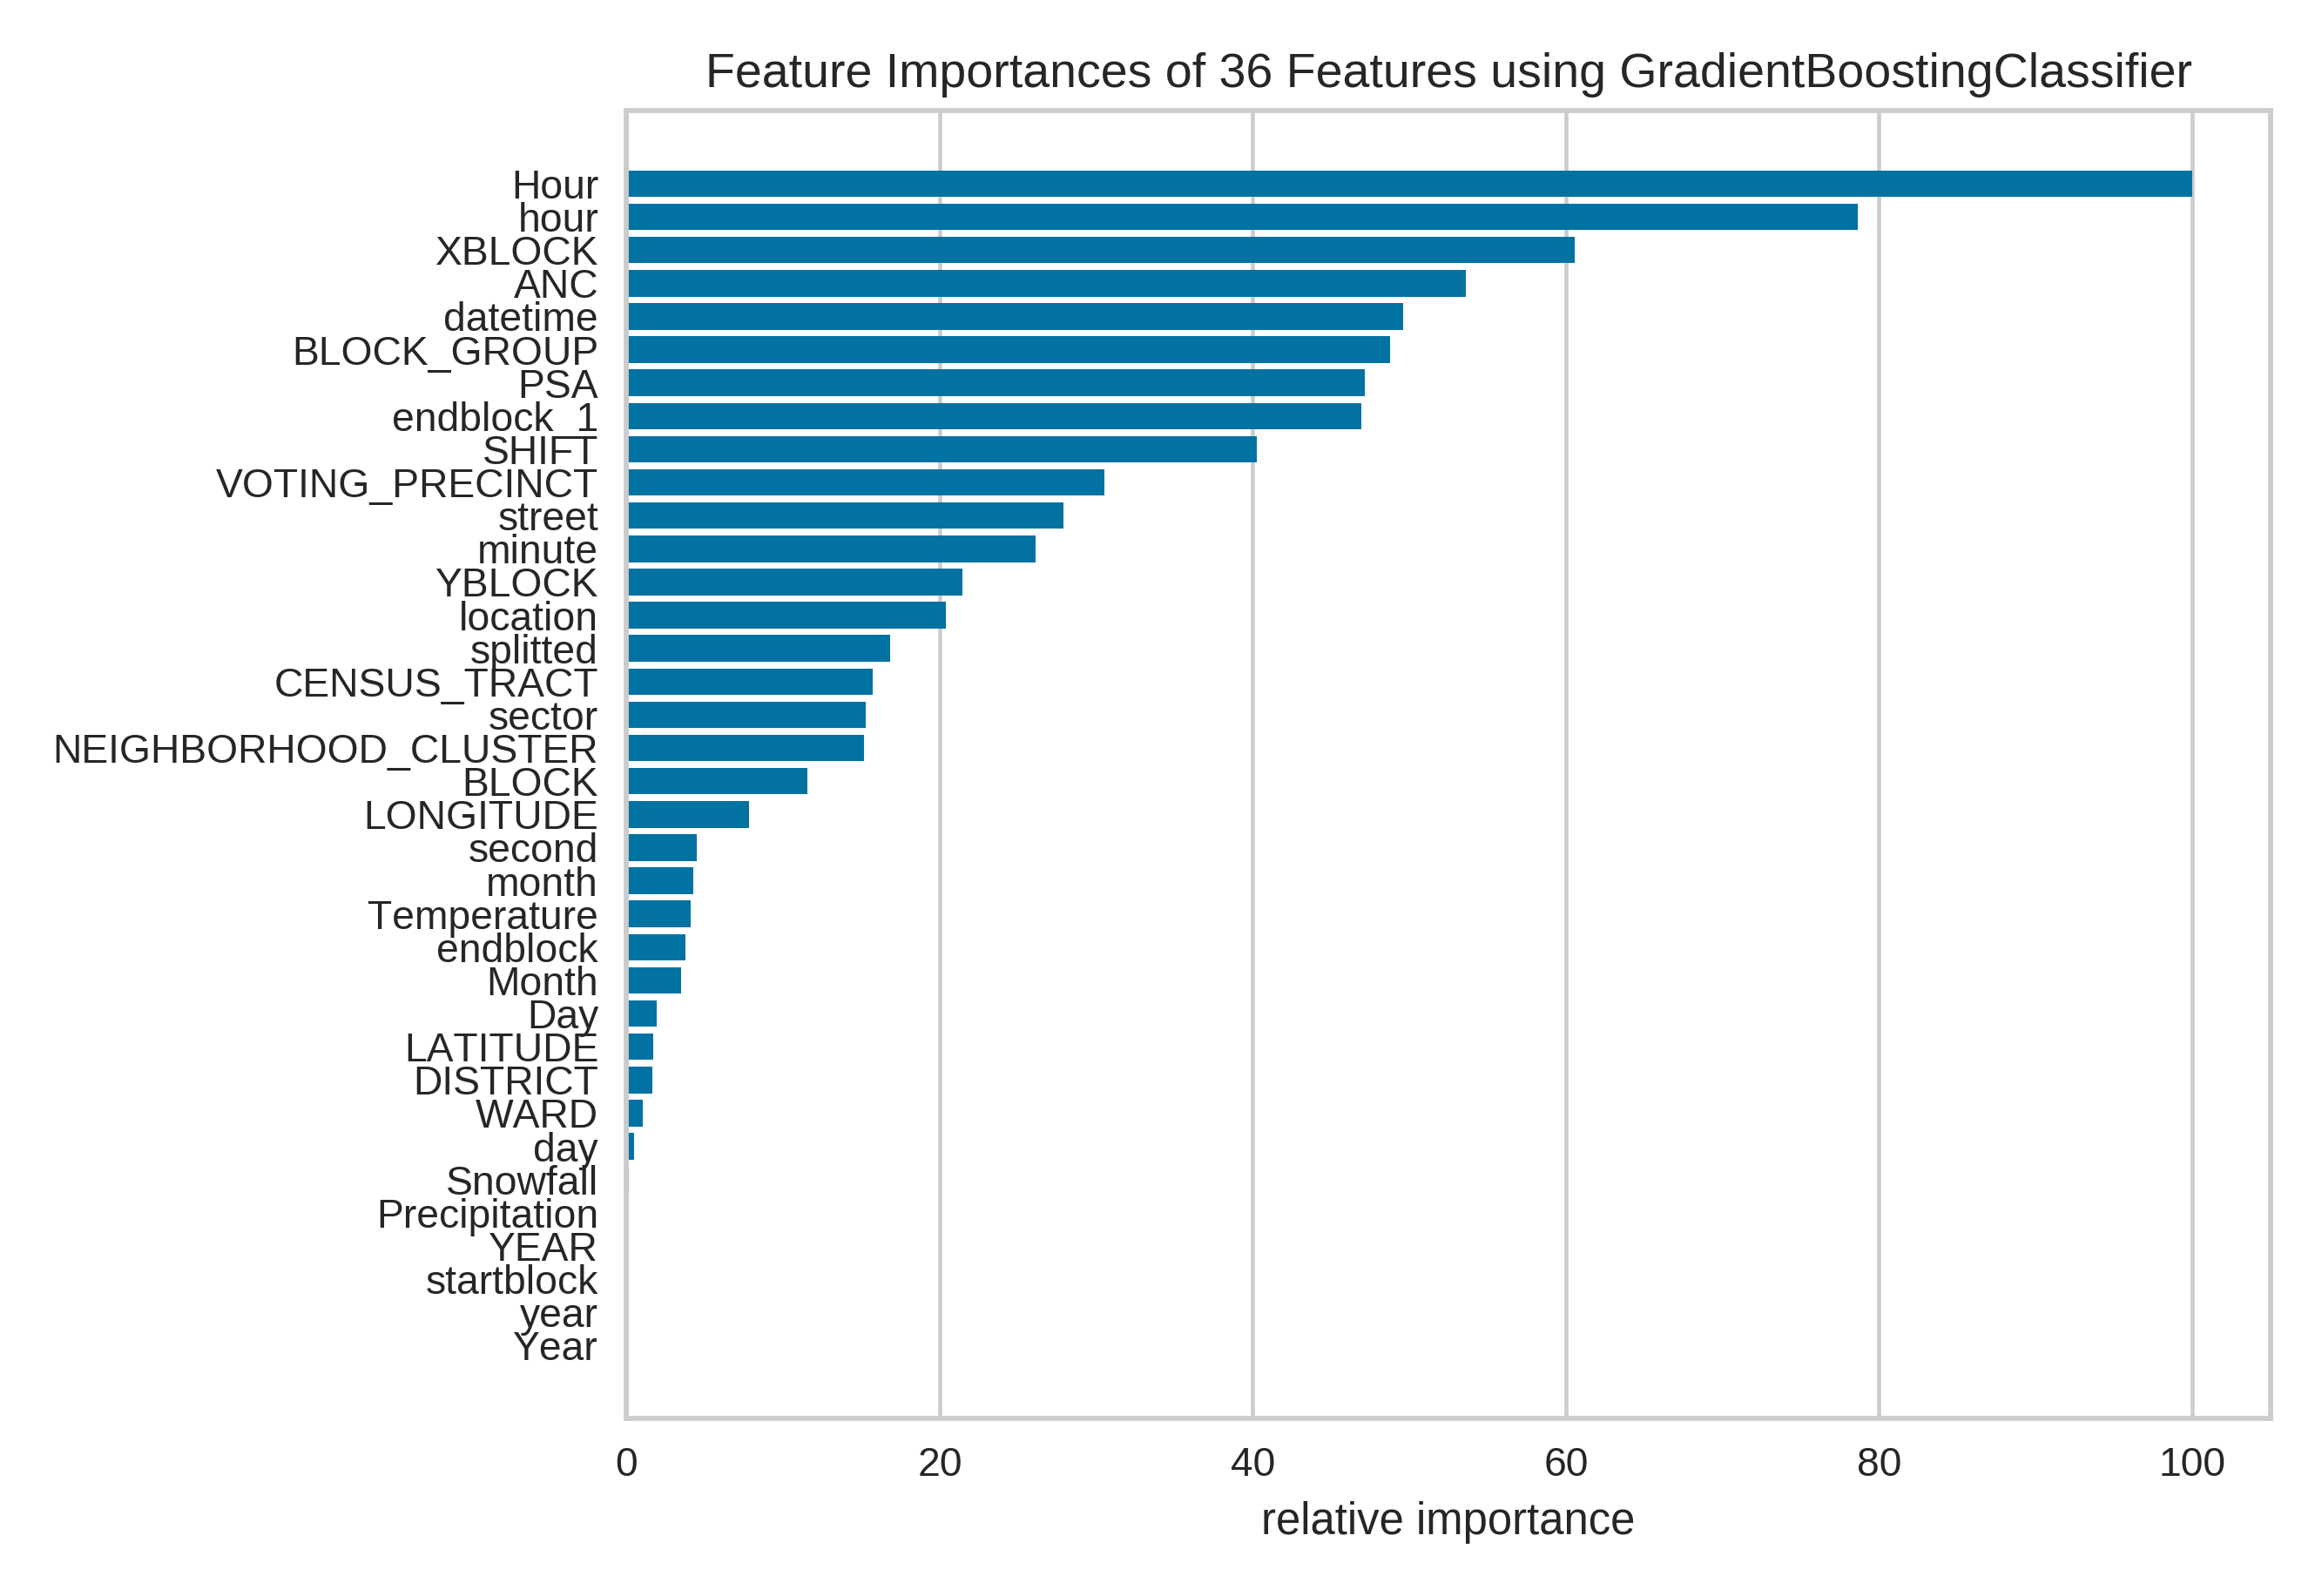

In [222]:
from sklearn.ensemble import GradientBoostingClassifier
from yellowbrick.features.importances import FeatureImportances
fig = plt.figure()
ax = fig.add_subplot()

viz = FeatureImportances(GradientBoostingClassifier(), ax=ax)
viz.fit(Xi, yi)
viz.poof()

In [223]:
with open('Feature_importance.pickle', 'wb') as figure1:
    
    pickle.dump([fig,ax, viz] , figure1)

In [ ]:
with open('Feature_importance.pickle', 'rb') as fig1:
    
    object_list = pickle.load(fig1)

In [240]:
y_ = y.reshape(-1, 1)

<IPython.core.display.Javascript object>


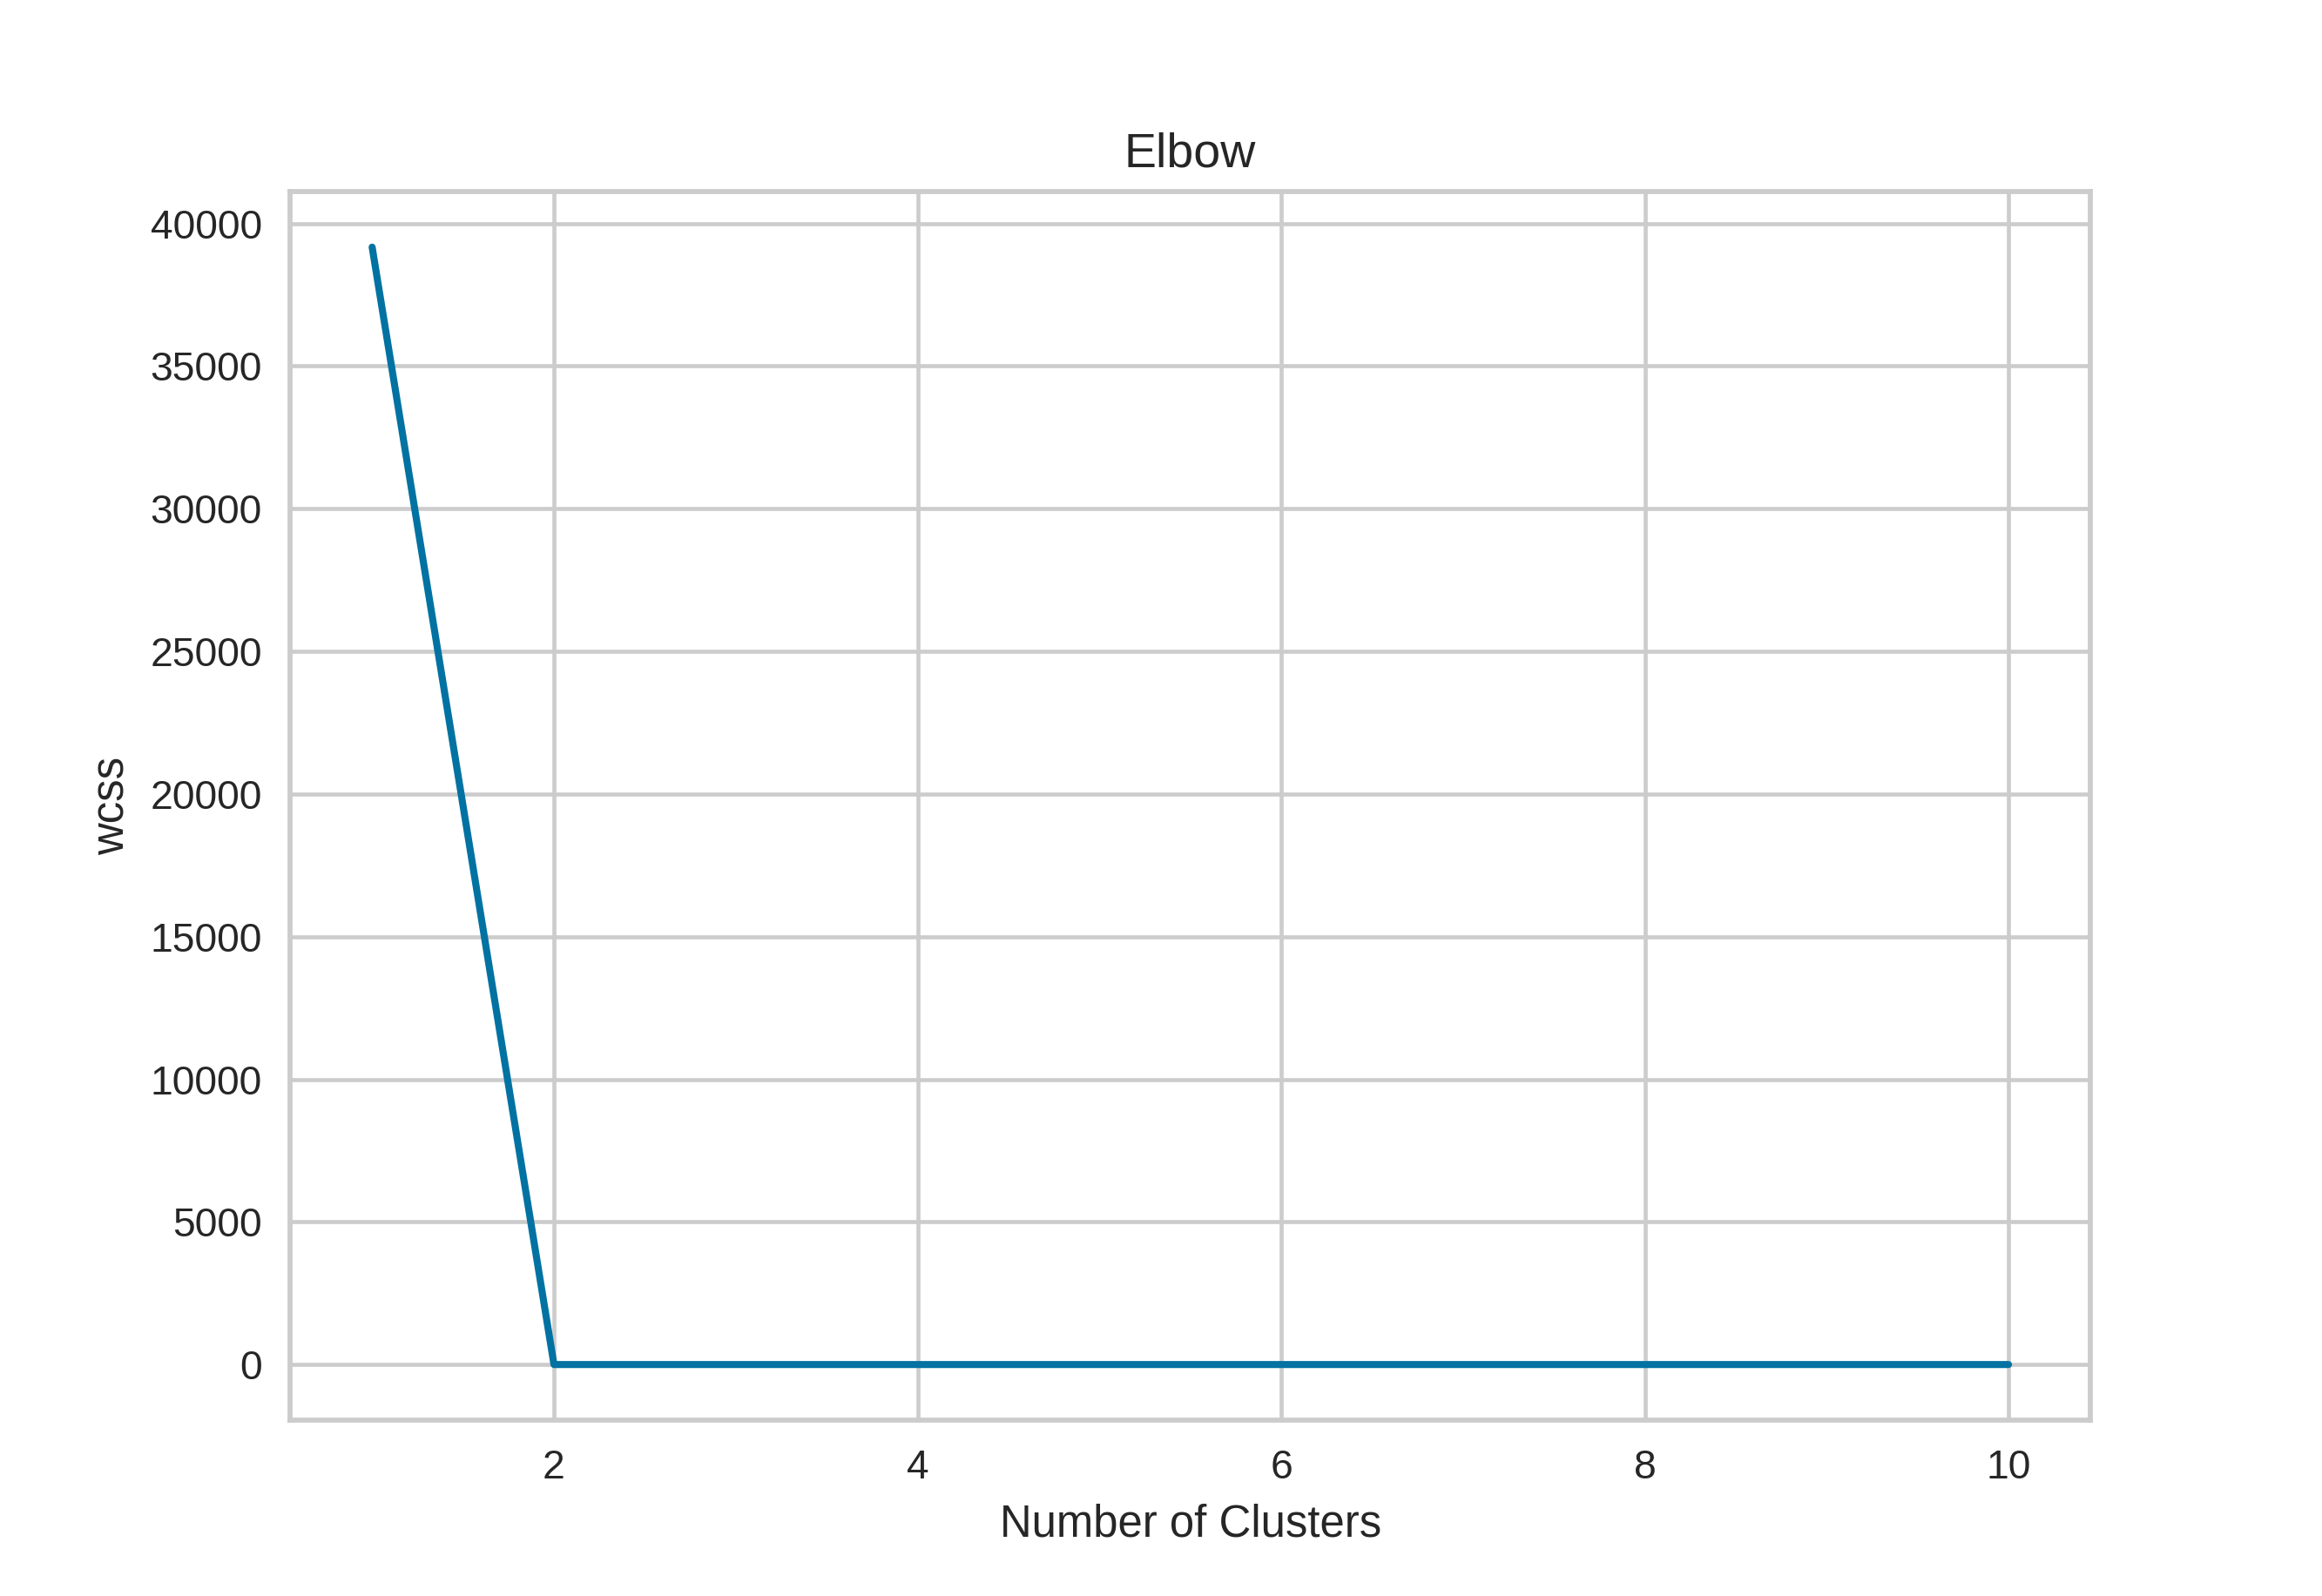

In [241]:
from sklearn.cluster import KMeans
wcss = []

for i in range(1,11):
    kmeans = KMeans(n_clusters = i, random_state=0, max_iter=300, init='k-means++', n_init=10)
    kmeans.fit(y_)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11), wcss)
plt.title('Elbow')
plt.xlabel('Number of Clusters')
plt.ylabel('wcss')
plt.show()    

<IPython.core.display.Javascript object>


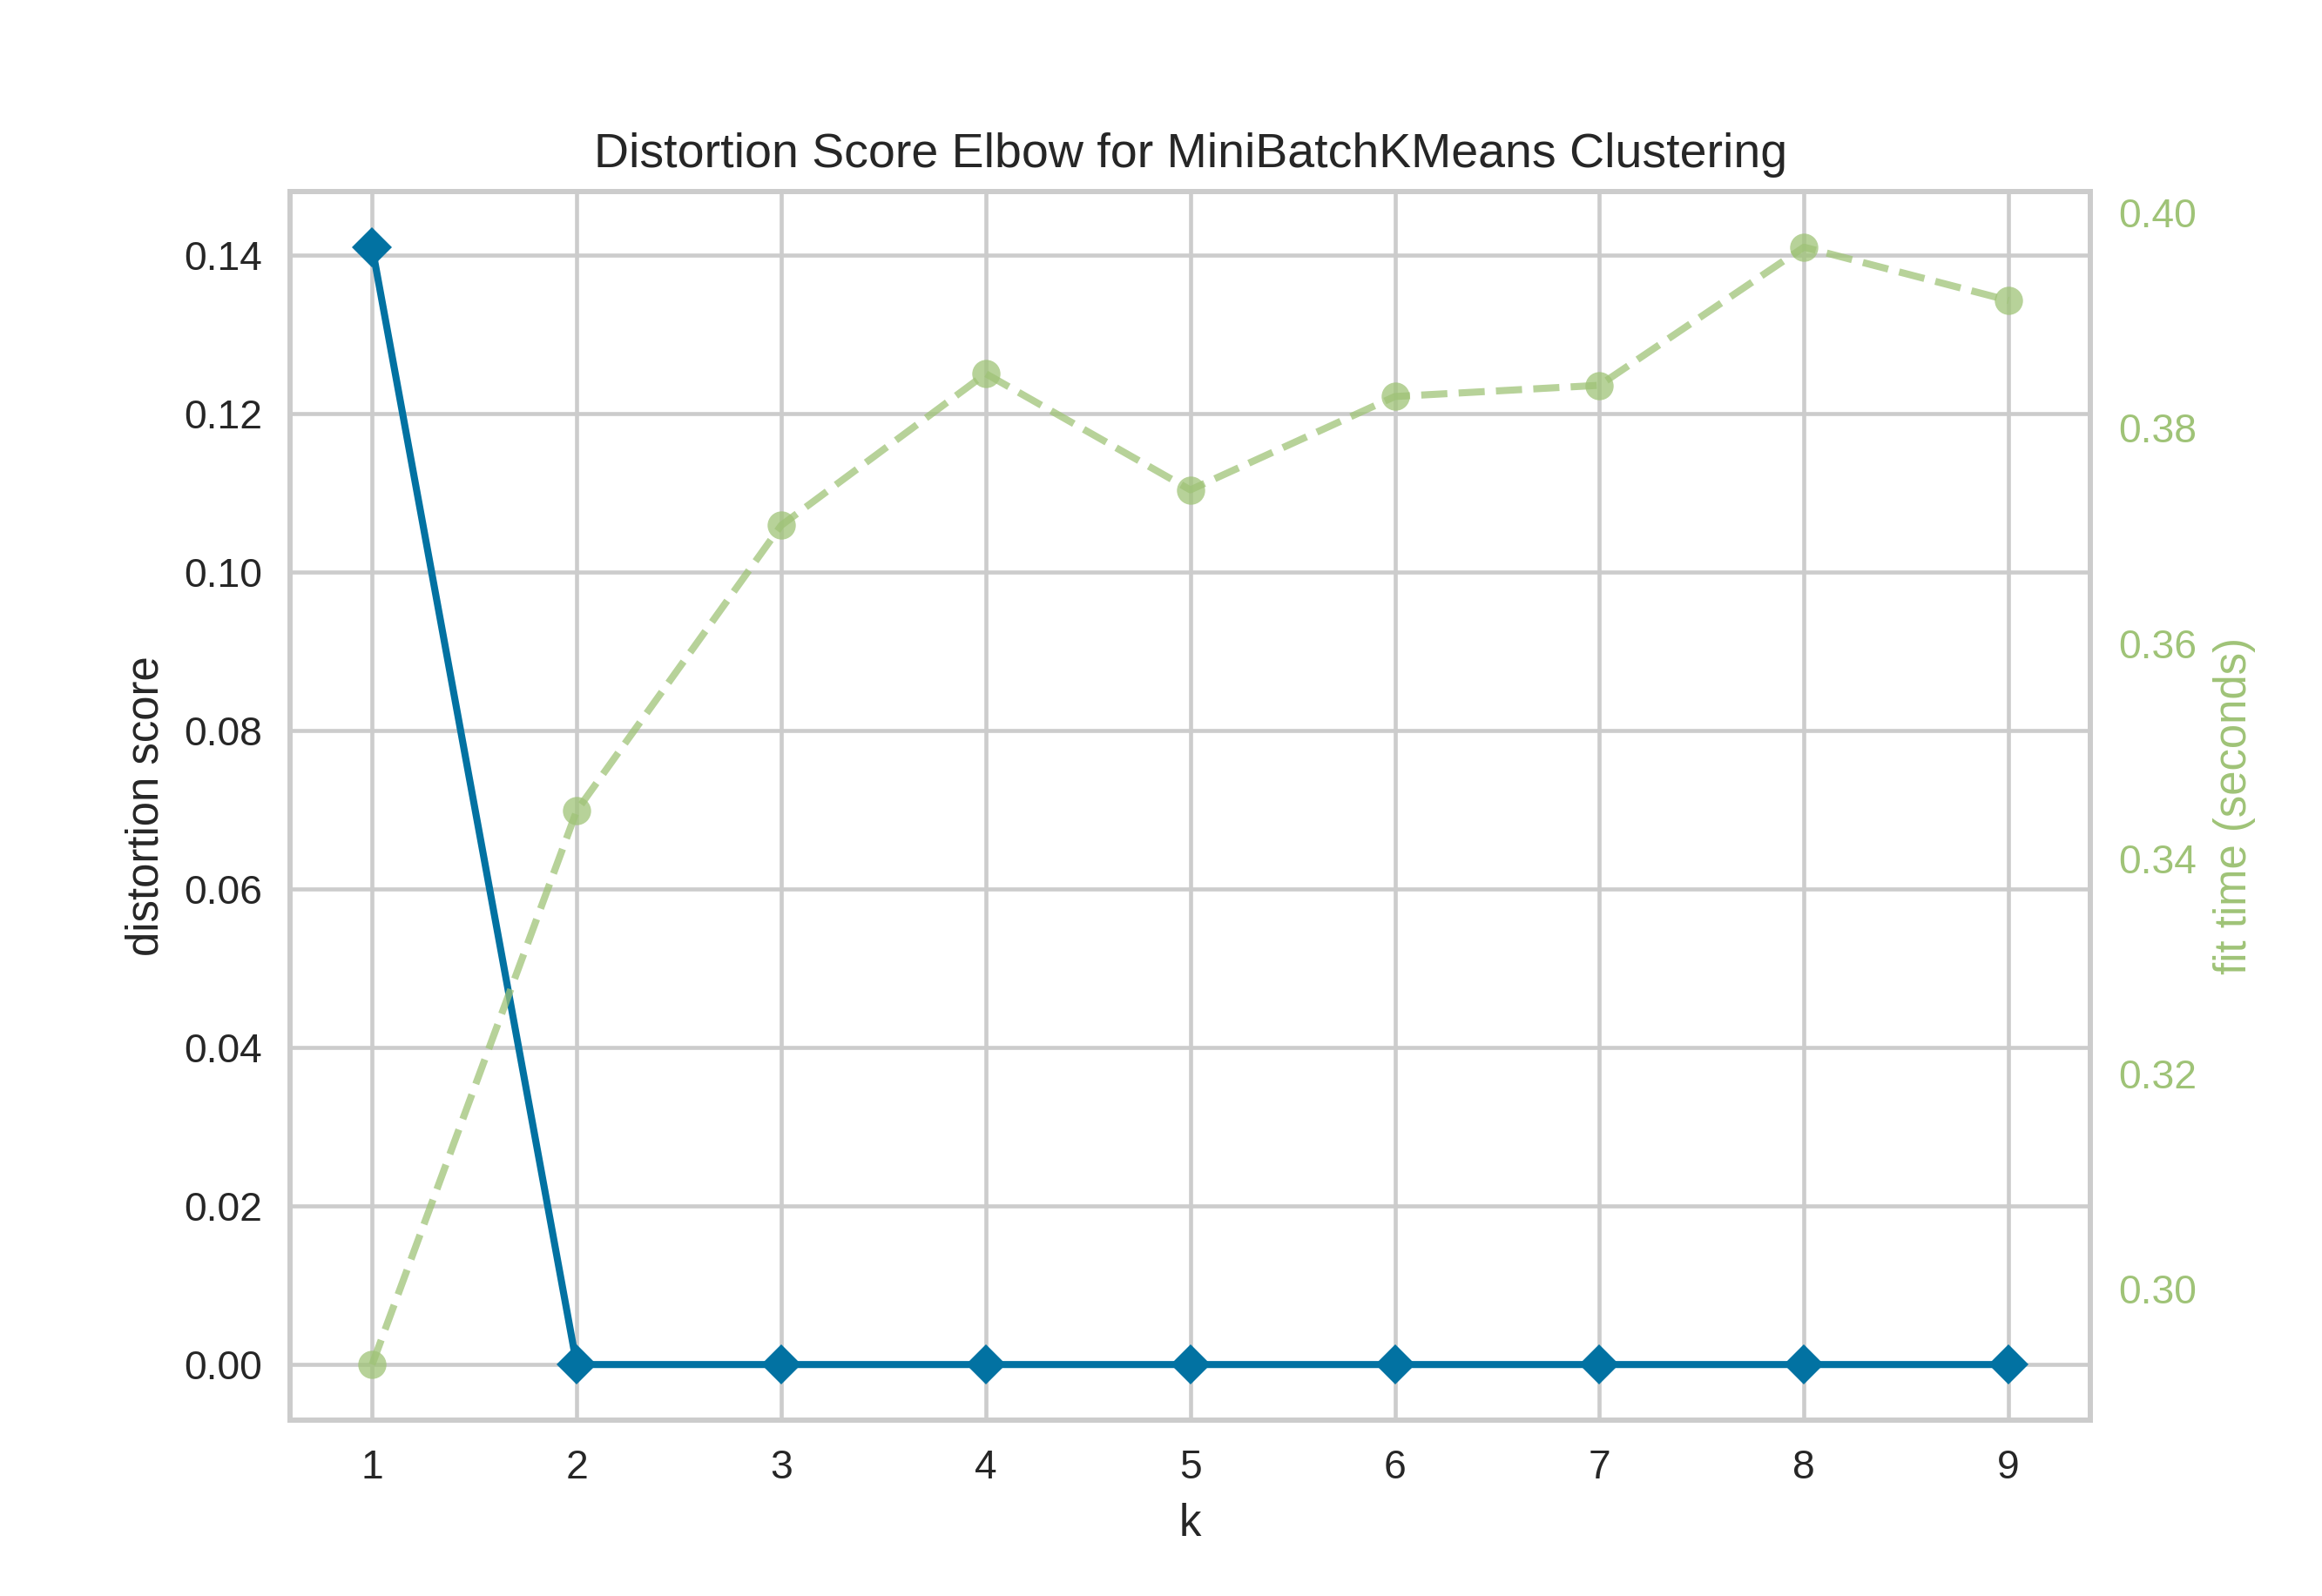

In [242]:
from sklearn.cluster import MiniBatchKMeans

from yellowbrick.cluster import KElbowVisualizer

visualizer = KElbowVisualizer(MiniBatchKMeans(), k=(1,10))

visualizer.fit(y_) # Fit the training data to the visualizer
visualizer.poof() # Draw/show/poof the data

#    --------------------MODEL SELECTION---------------------------------



In [118]:
from sklearn.pipeline import Pipeline
from yellowbrick.classifier import ClassificationReport
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier

In [119]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2,random_state= 0)

In [120]:
scaler = StandardScaler()
#scaler =  MinMaxScaler()
#scaler = Normalizer()
X_train = scaler.fit(X_train).transform(X_train)
X_test = scaler.fit(X_test).transform(X_test)

In [121]:
def classifier_graph(classifier):
    classes = ['Nonviolent','Violent'] # 1 is 0 and 2 is 1..... non violent and violent respectively.
    model = classifier
    visualizer = ClassificationReport(model, classes=classes)



    visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
    visualizer.score(X_test, y_test)  # Evaluate the model on the test data
    g = visualizer.poof()             # Draw/show/poof the data

In [122]:
y__ = pd.Series(y)

In [123]:
y__.value_counts()

0    230621
1     47182
dtype: int64

In [ ]:
classifier_graph(KNeighborsClassifier(n_neighbors = 10, metric = 'manhattan', weights = 'distance', algorithm = 'auto'))

<IPython.core.display.Javascript object>


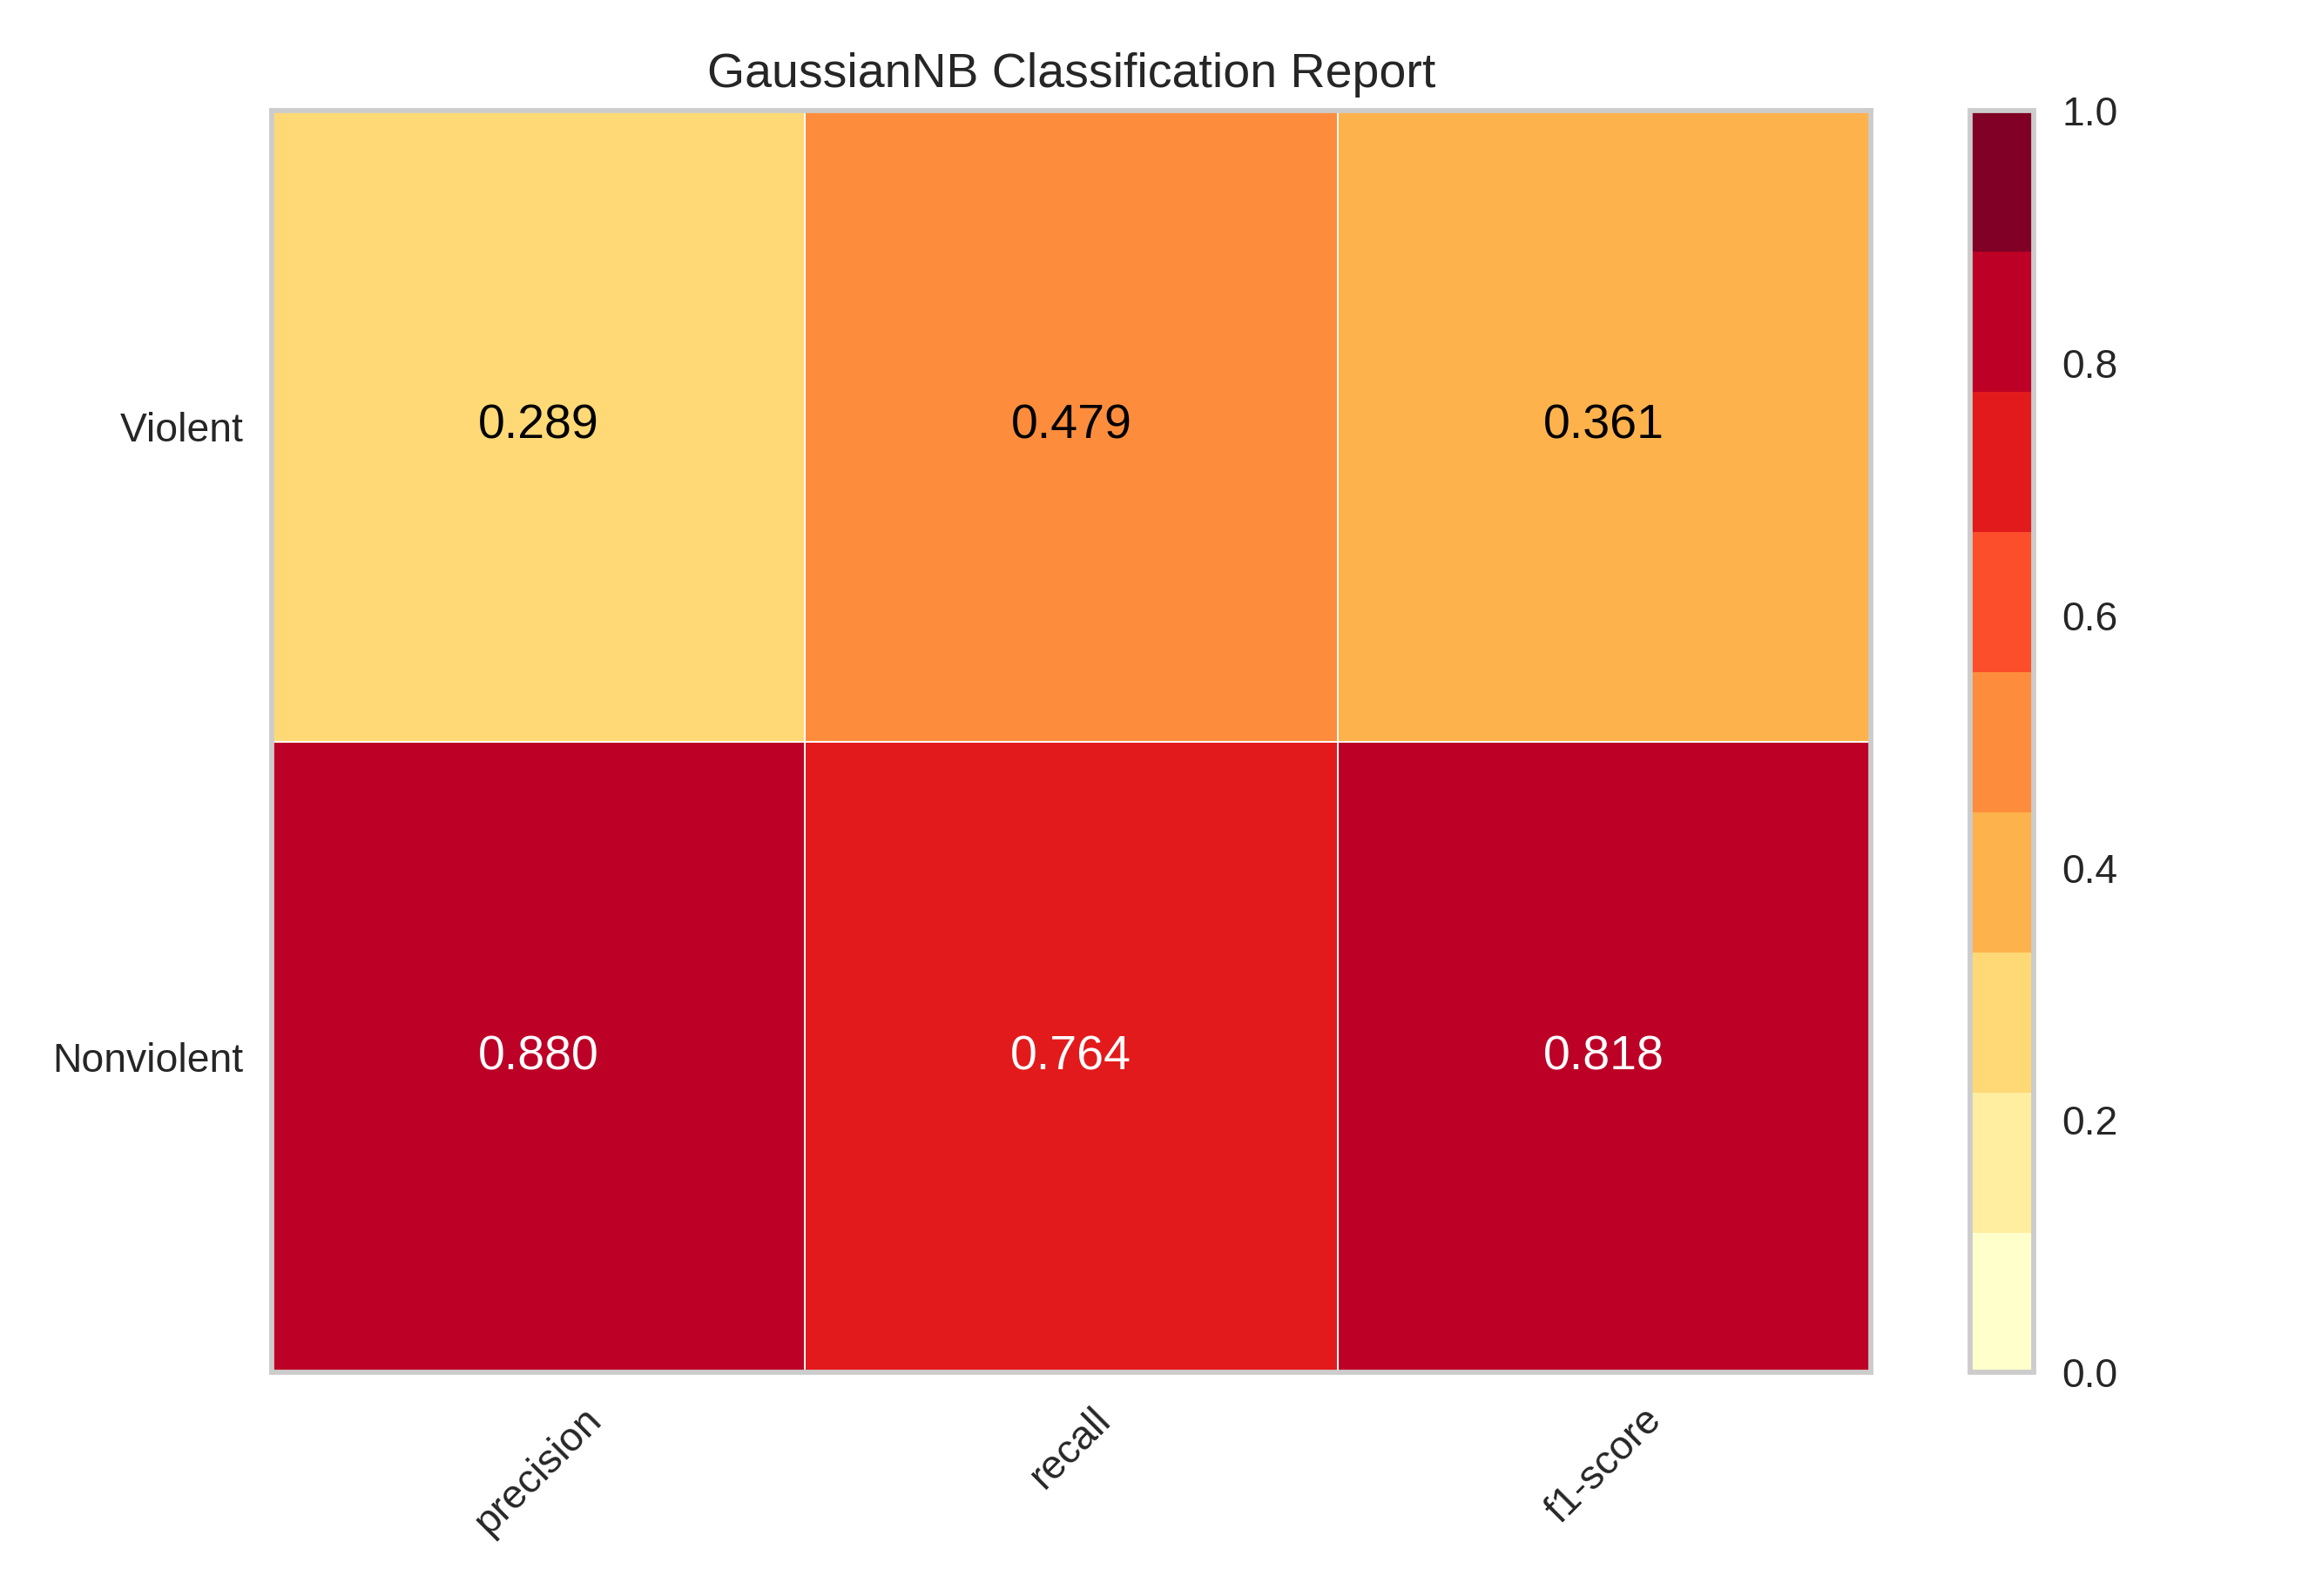

In [44]:
classifier_graph(GaussianNB())   

<IPython.core.display.Javascript object>


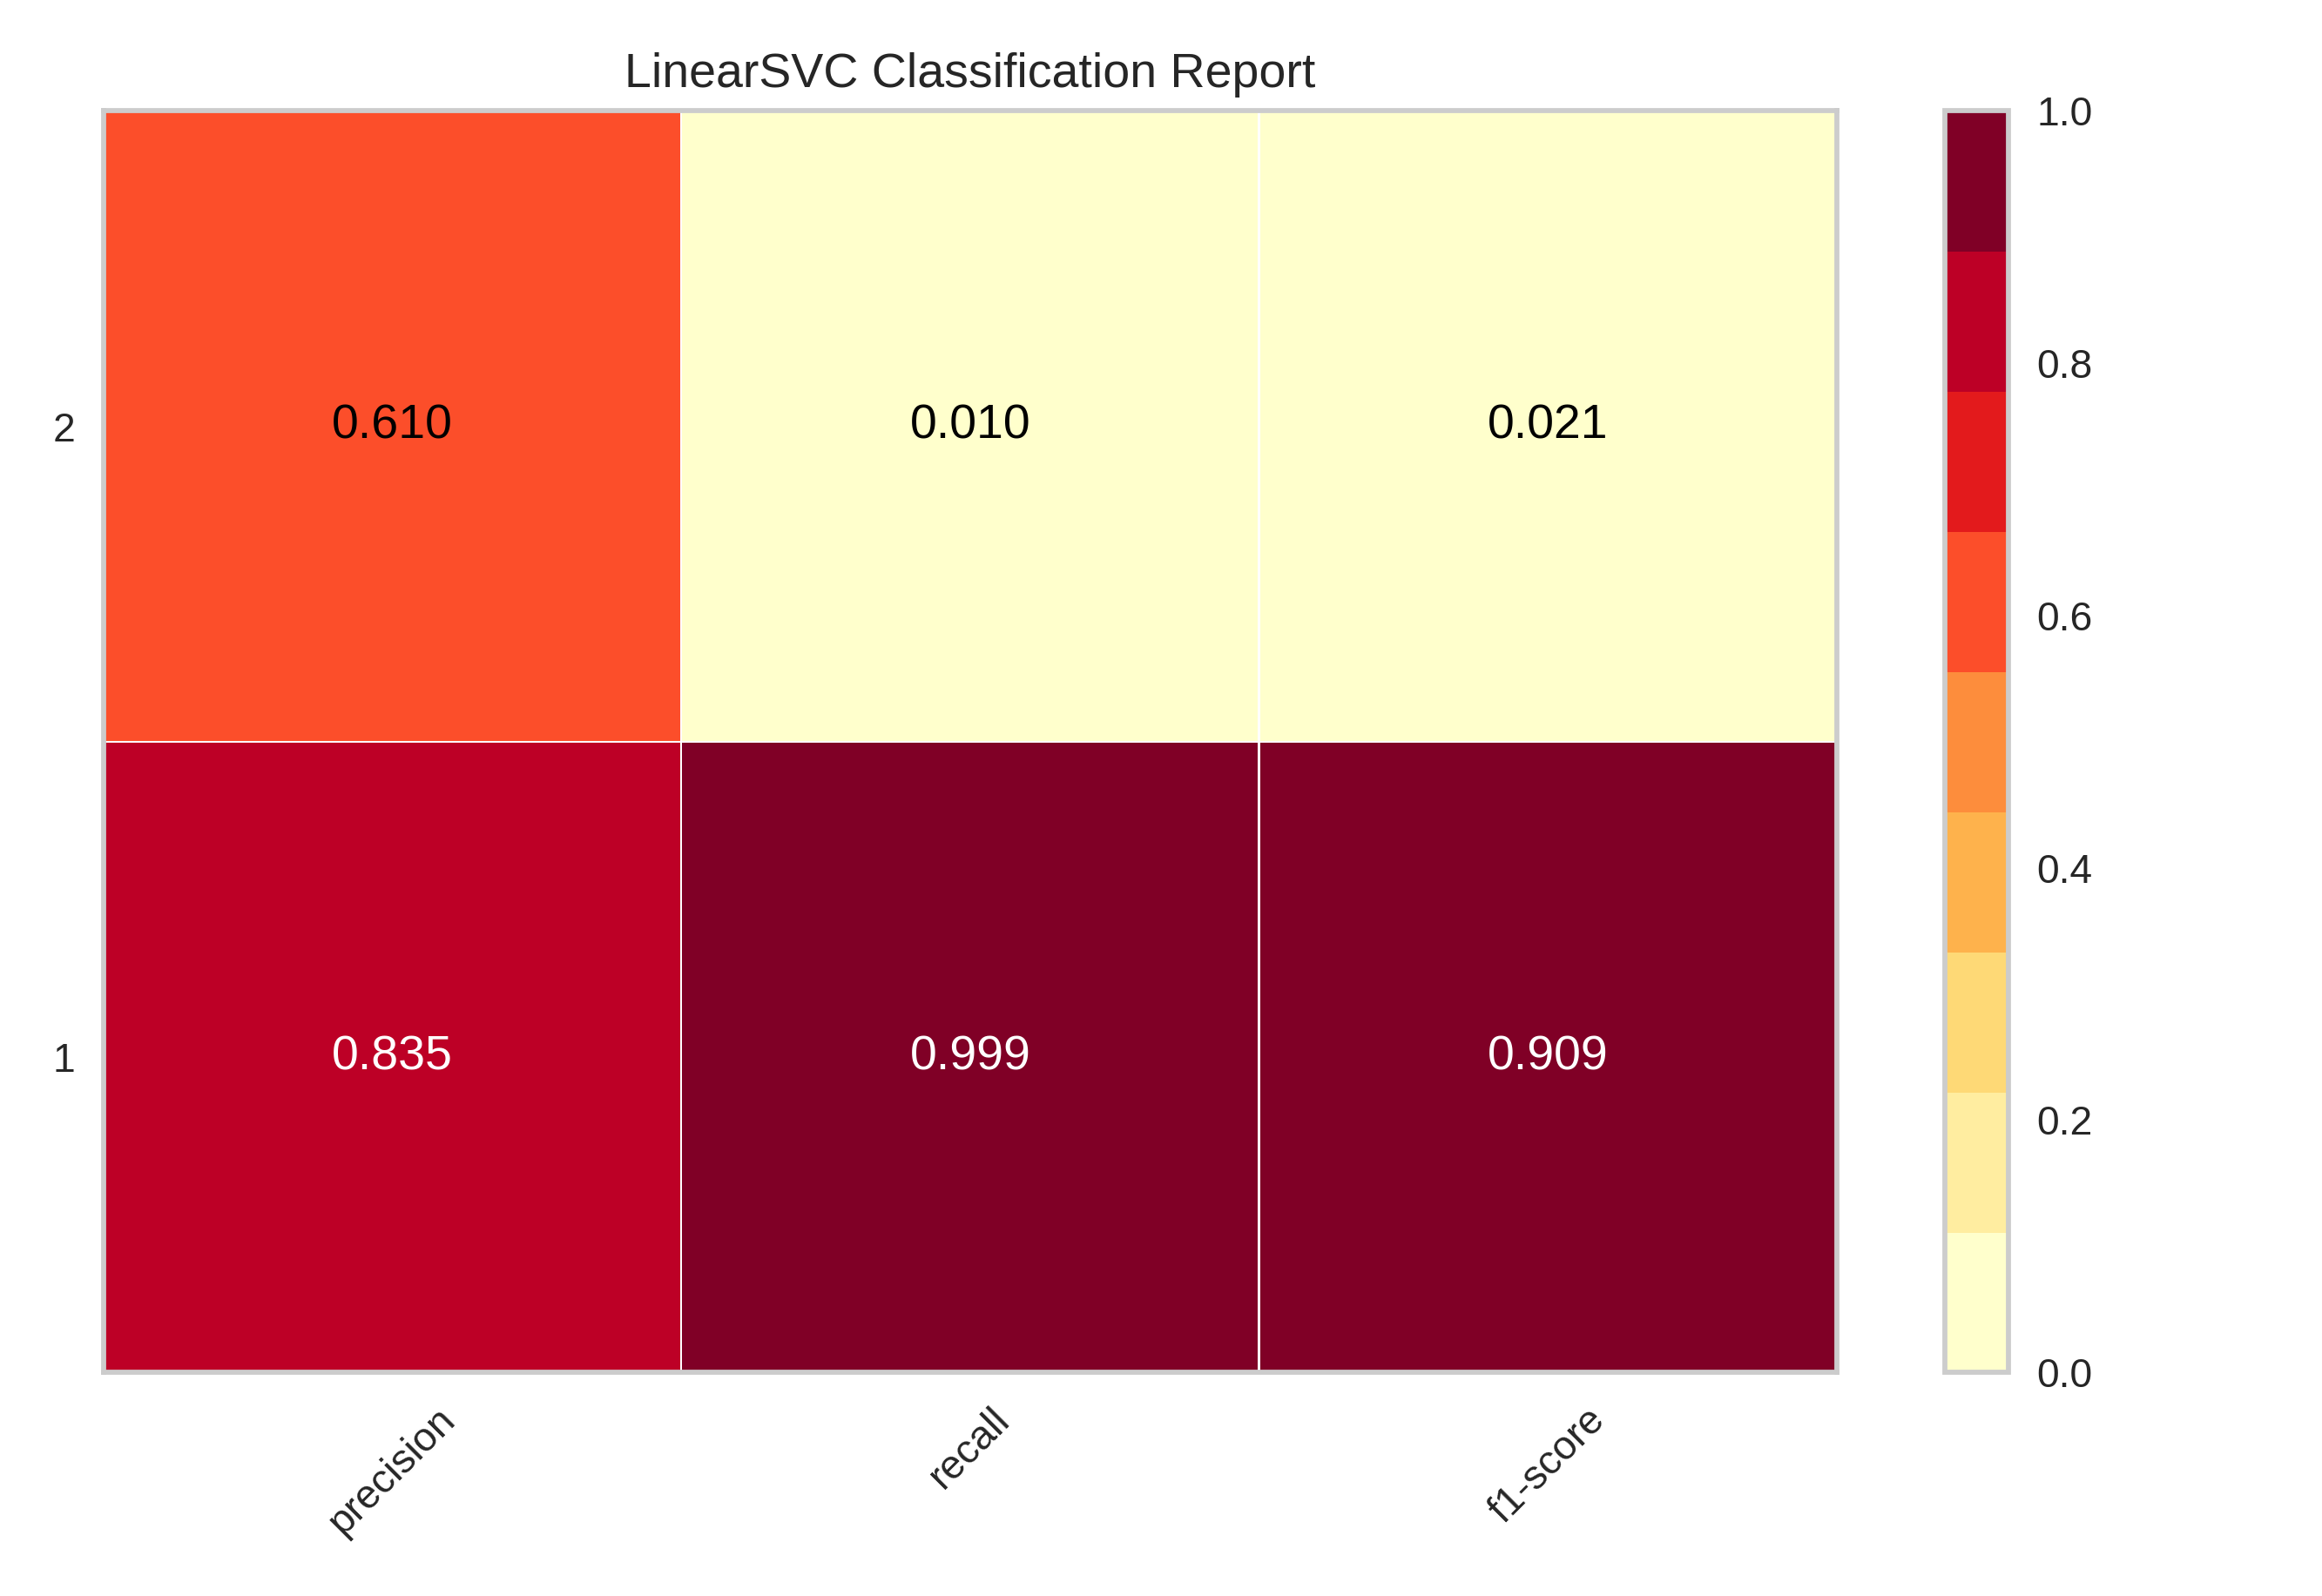

In [265]:
classifier_graph(LinearSVC())

In [ ]:
classifier_graph(SVC(C= 100, gamma = 0.01, kernel = 'rbf'))

<IPython.core.display.Javascript object>


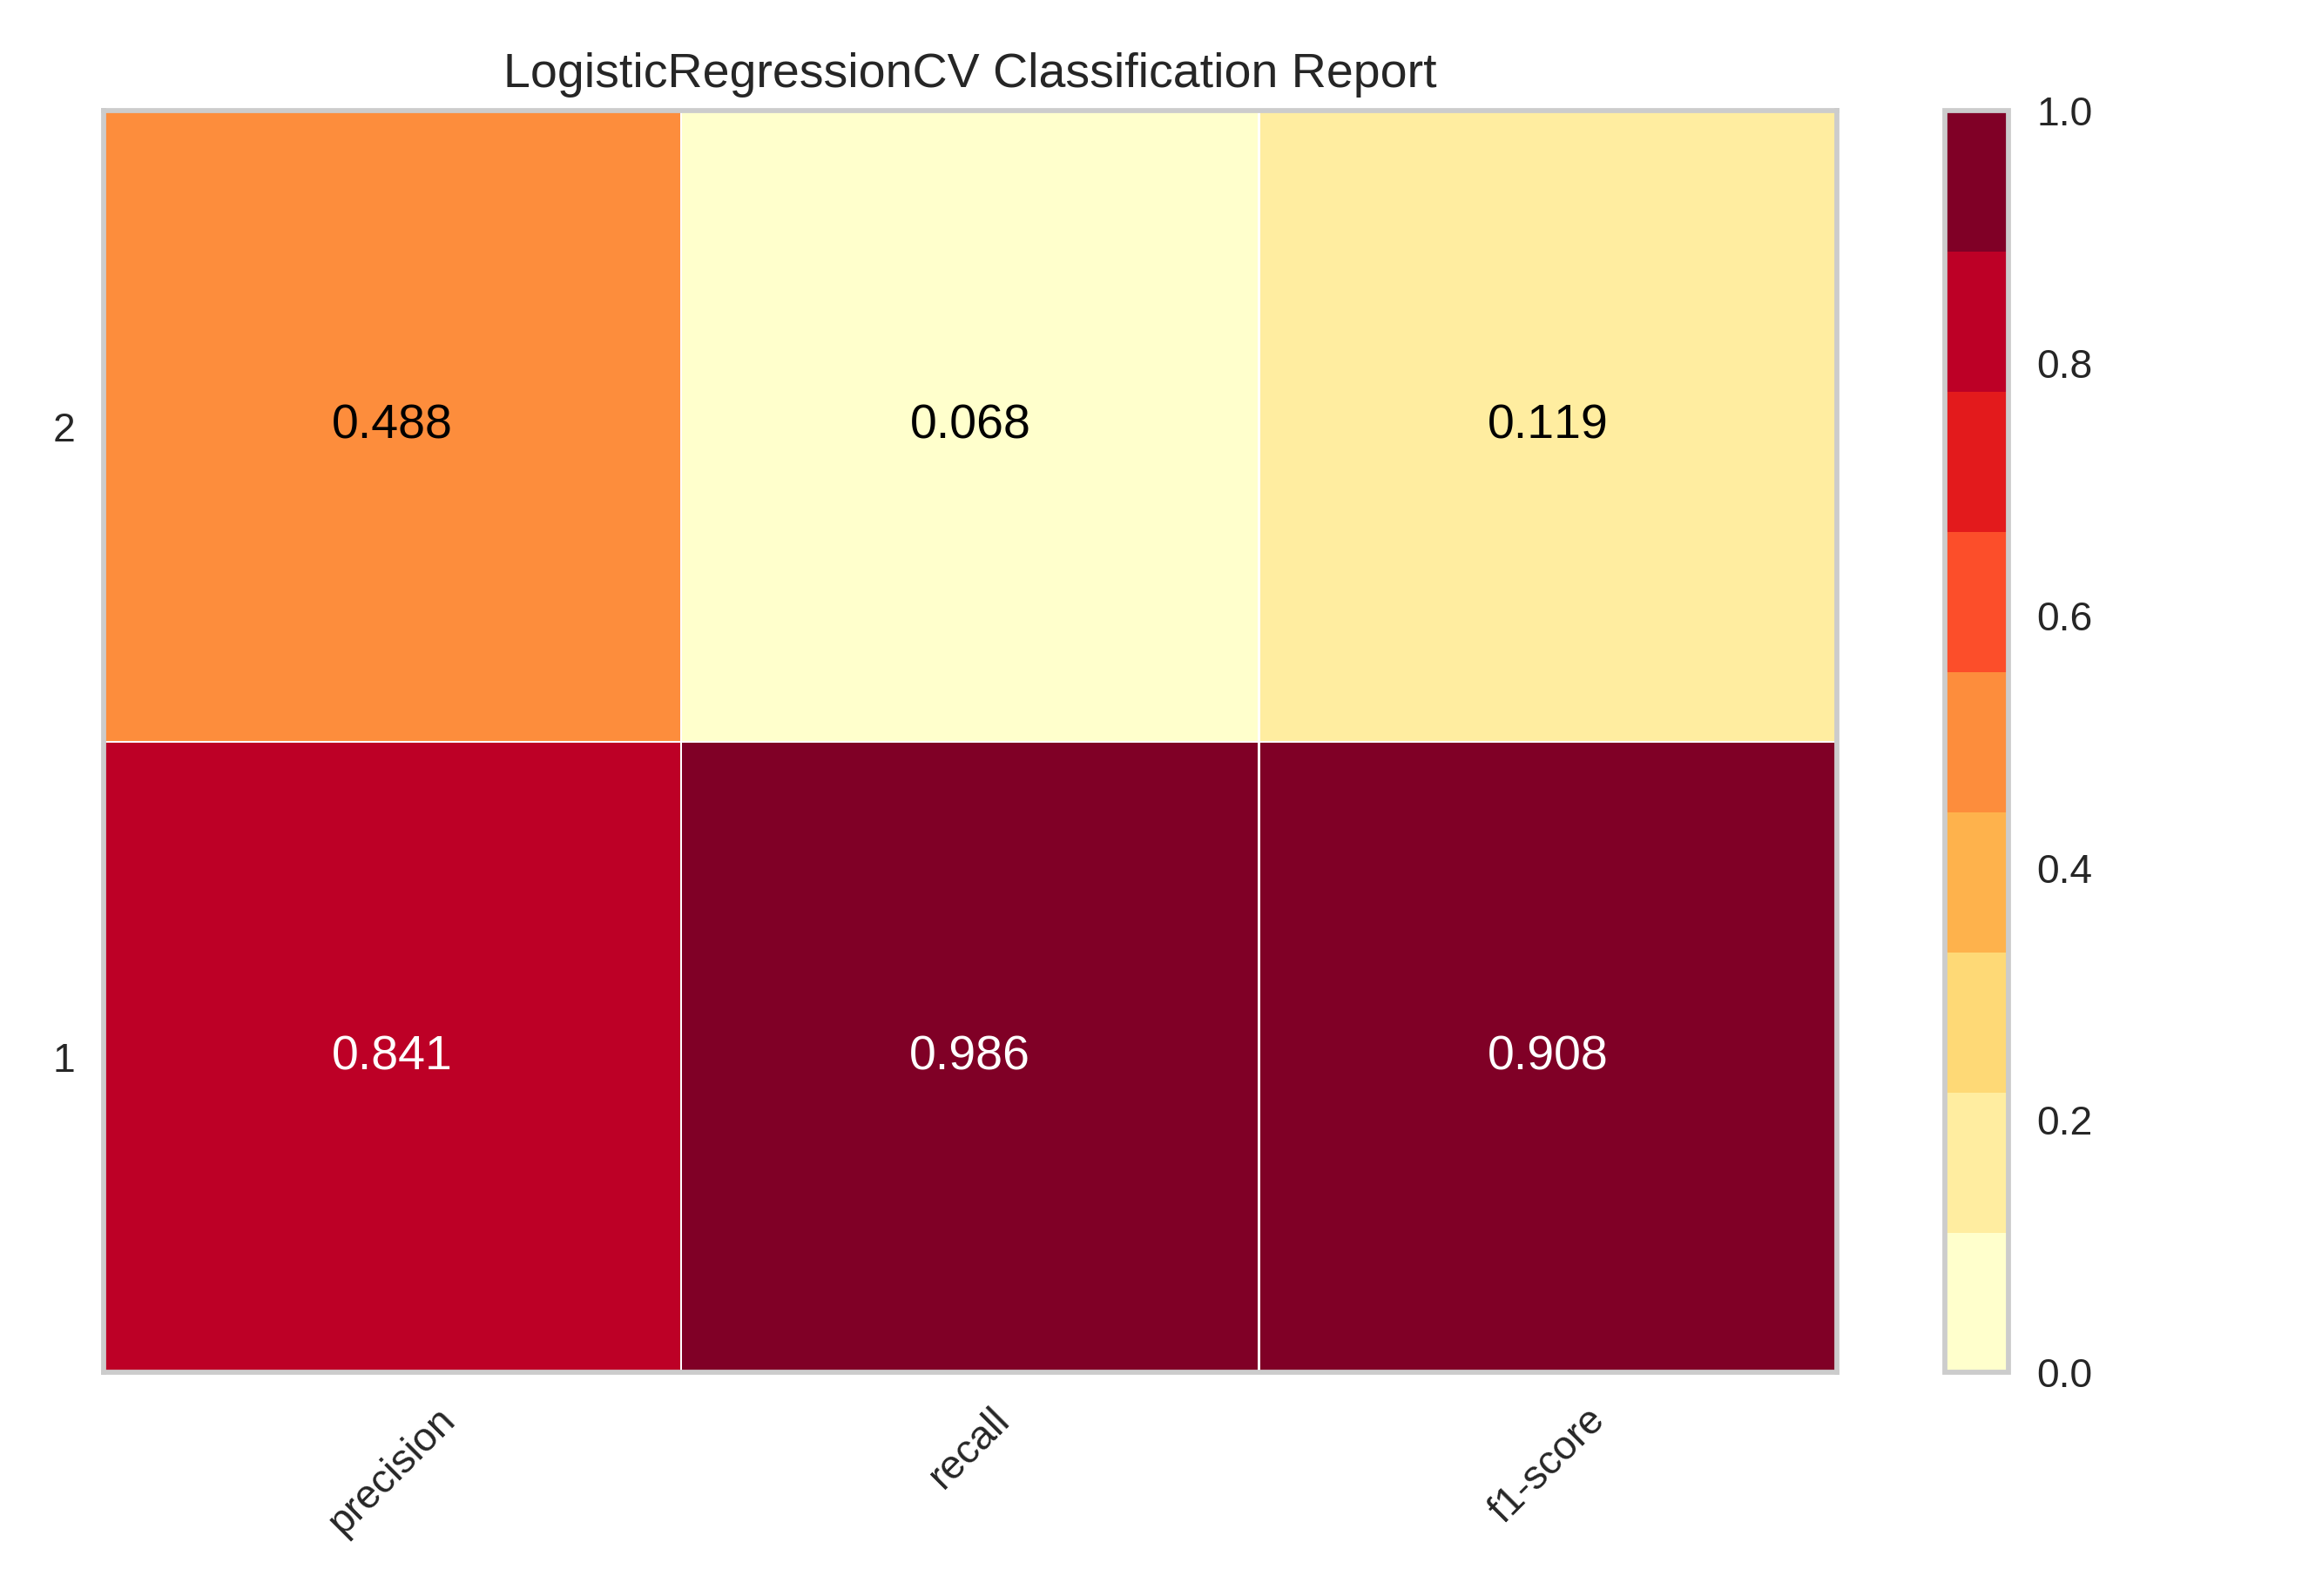

In [249]:
classifier_graph(LogisticRegressionCV())

<IPython.core.display.Javascript object>


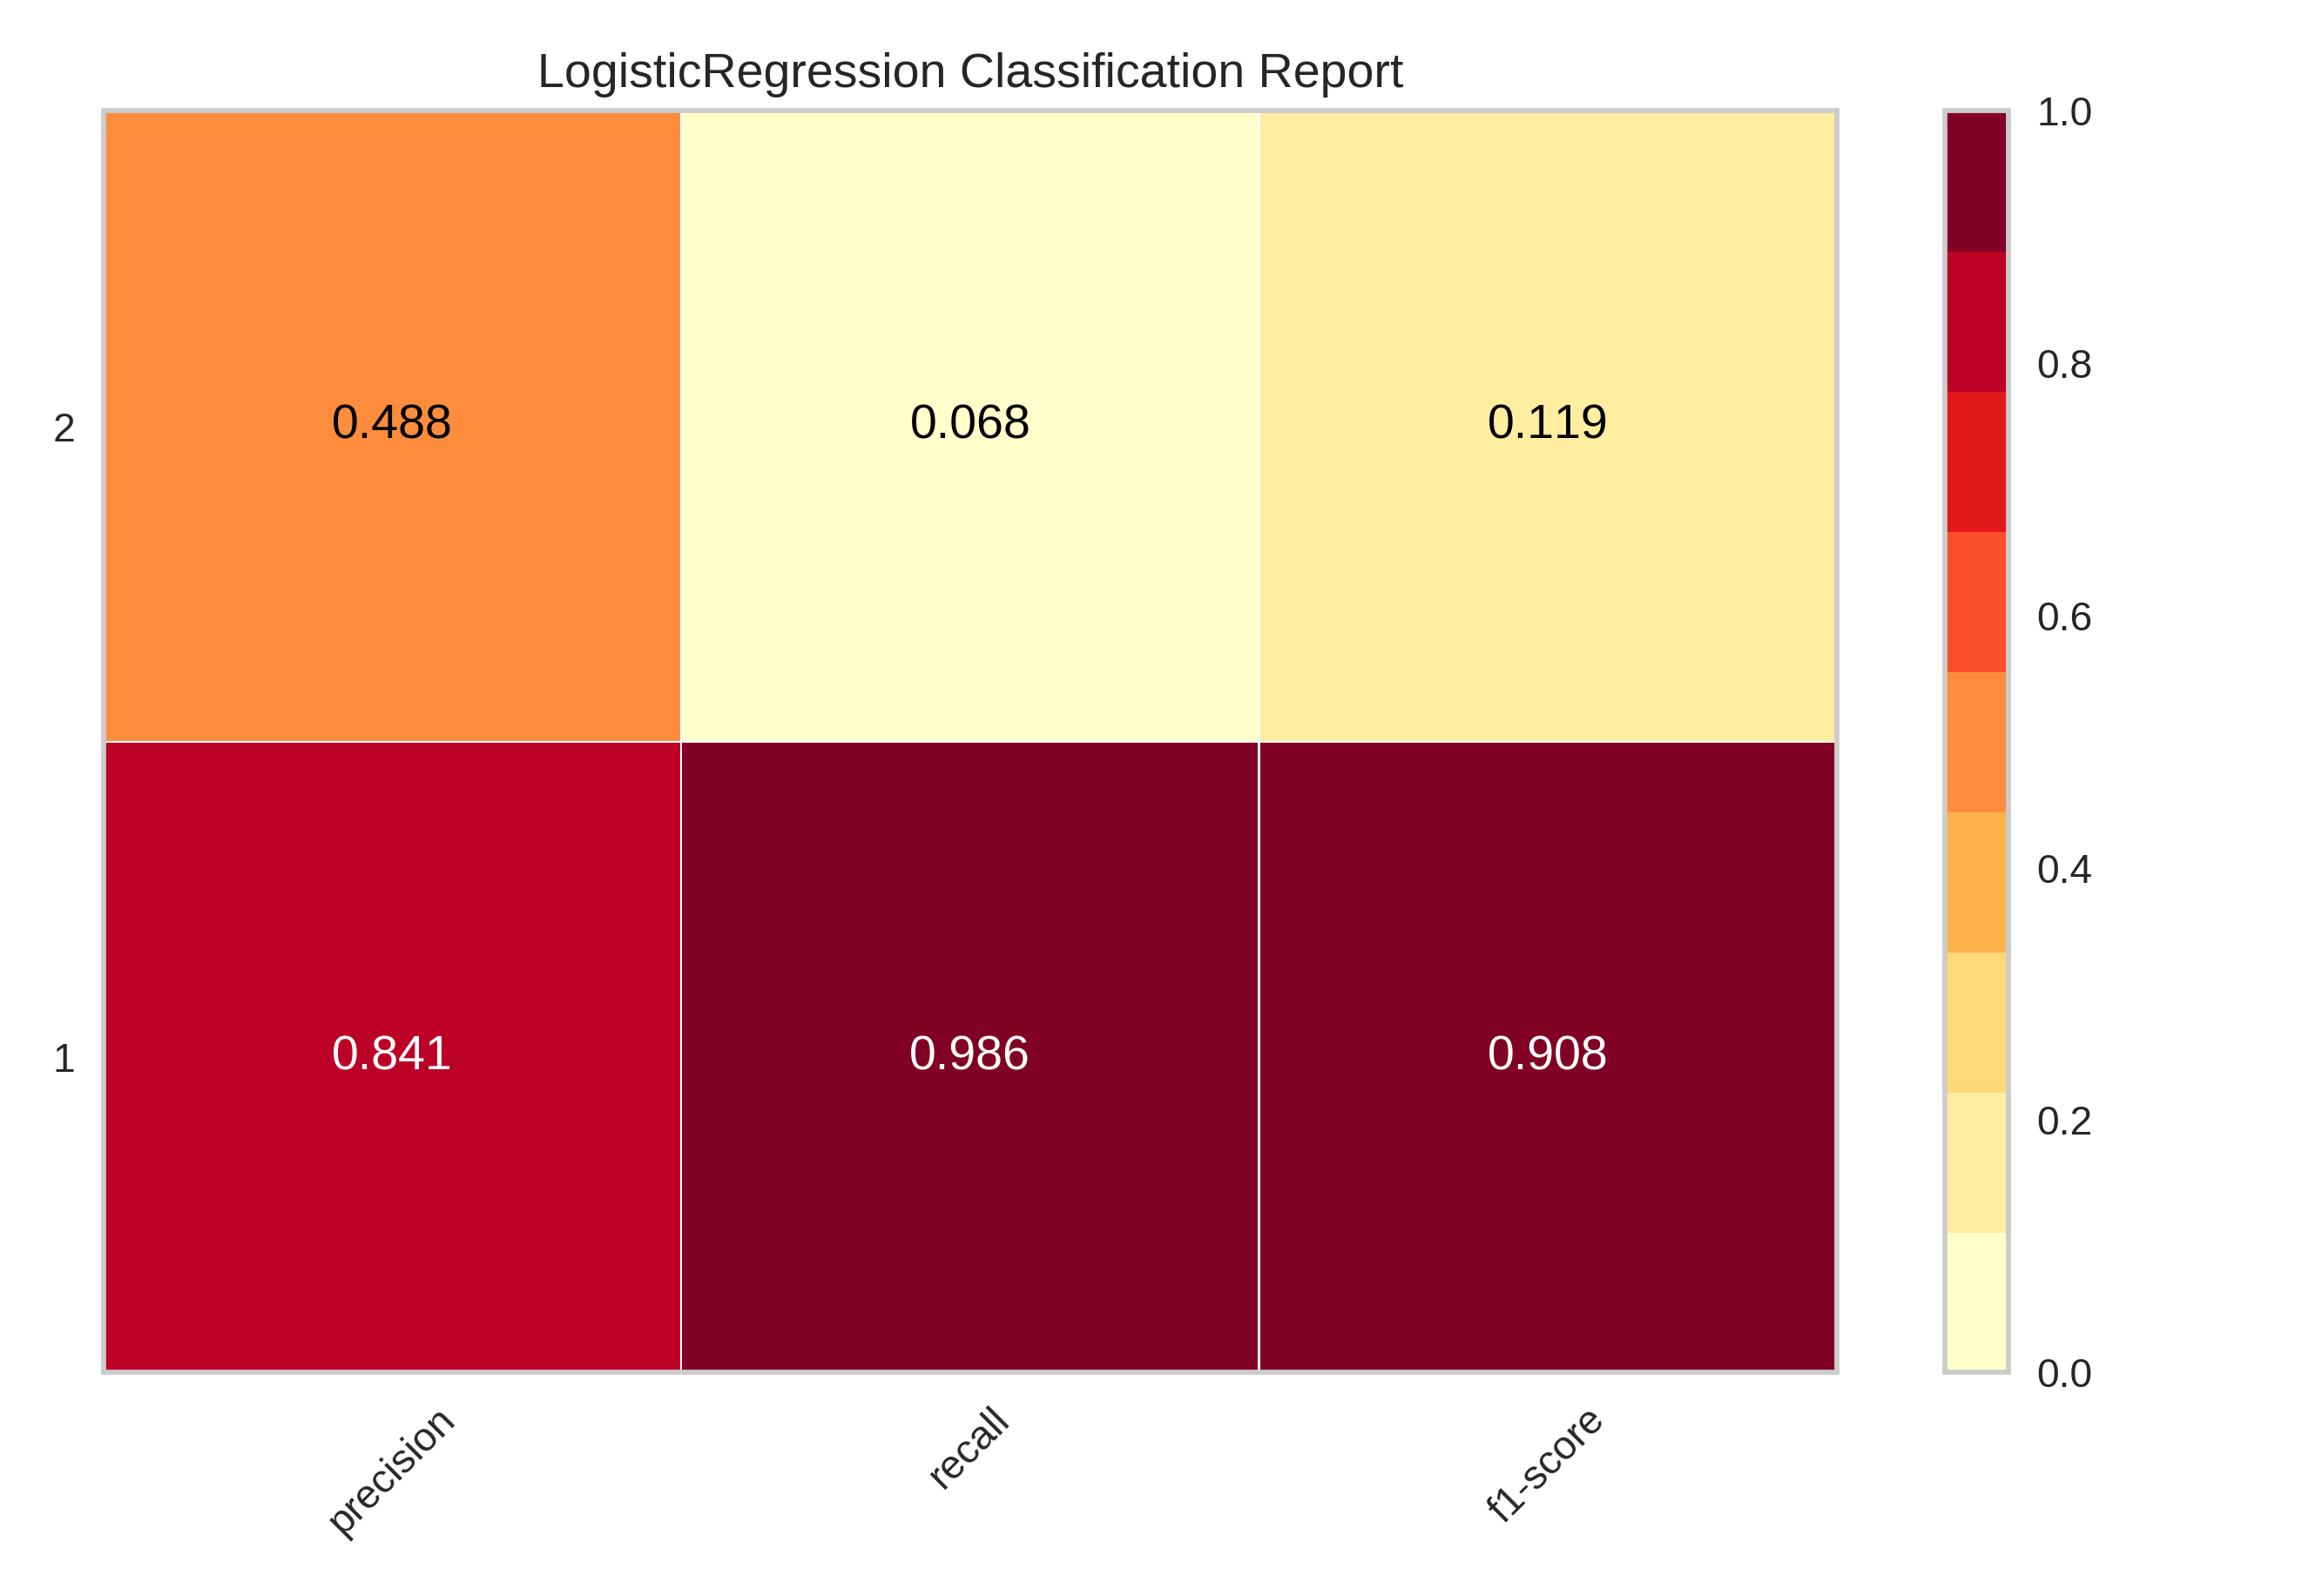

In [250]:
classifier_graph(LogisticRegression())

/home/franco/.local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


<IPython.core.display.Javascript object>


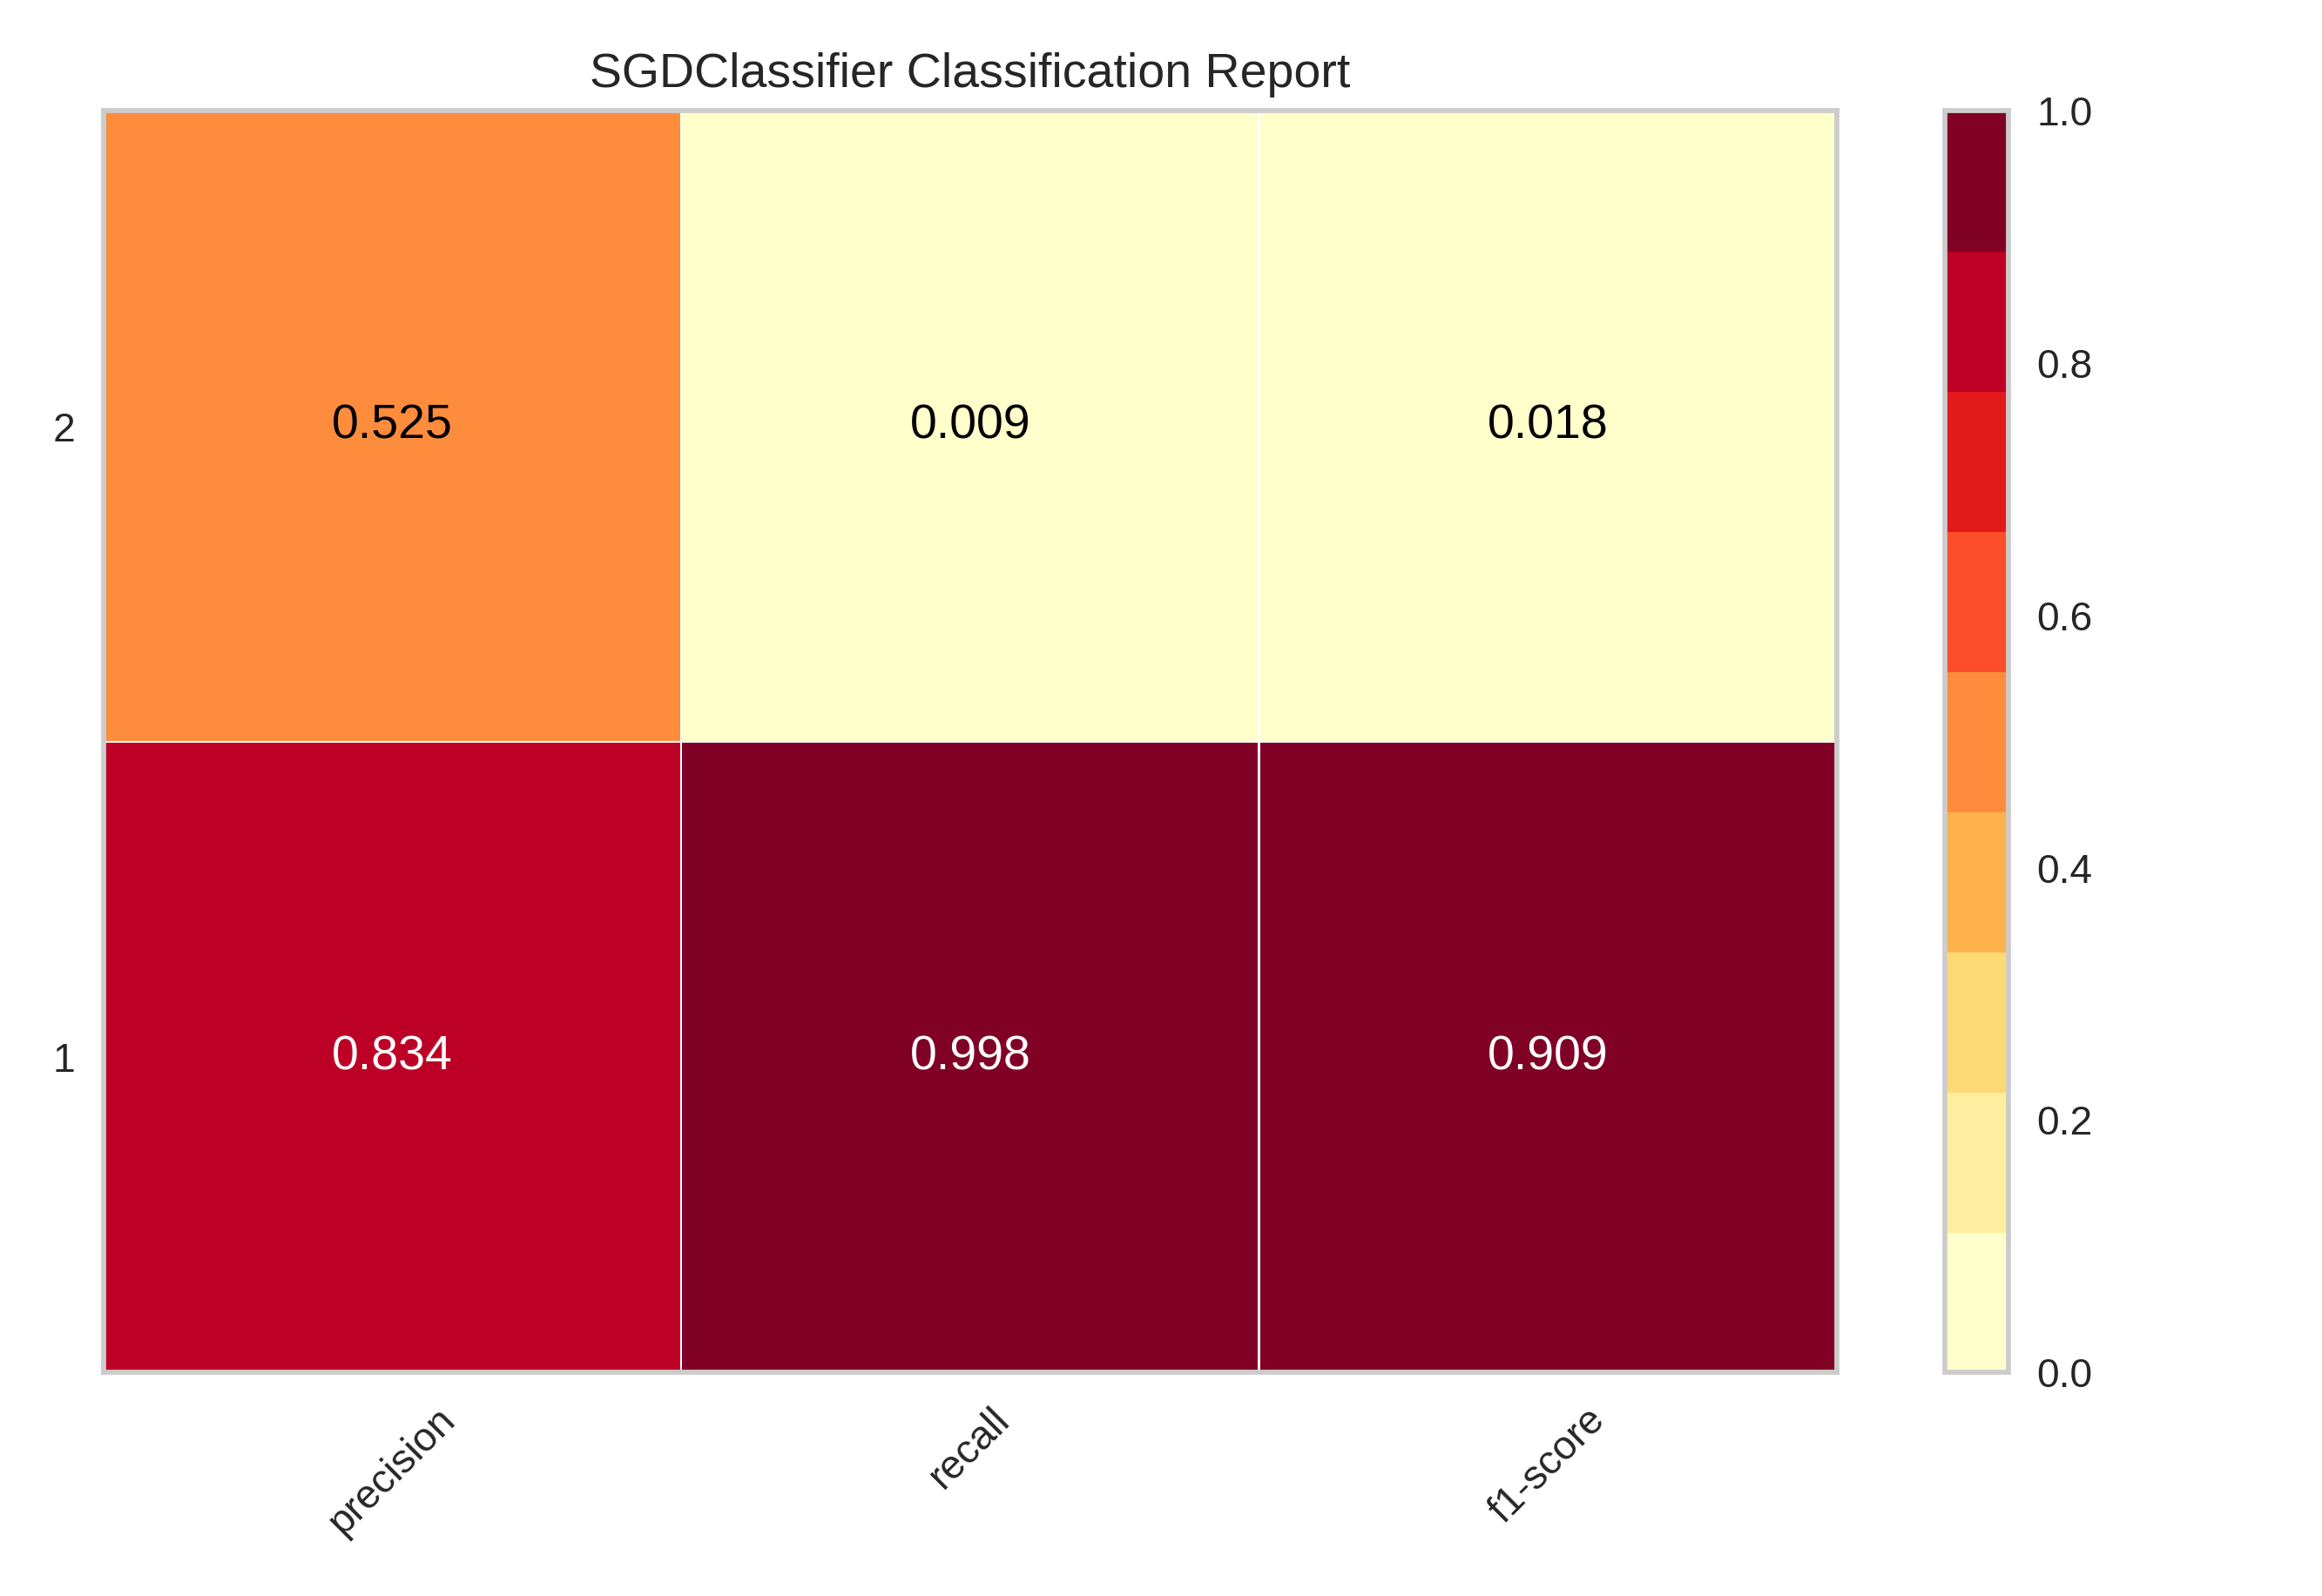

In [251]:
classifier_graph(SGDClassifier())

<IPython.core.display.Javascript object>


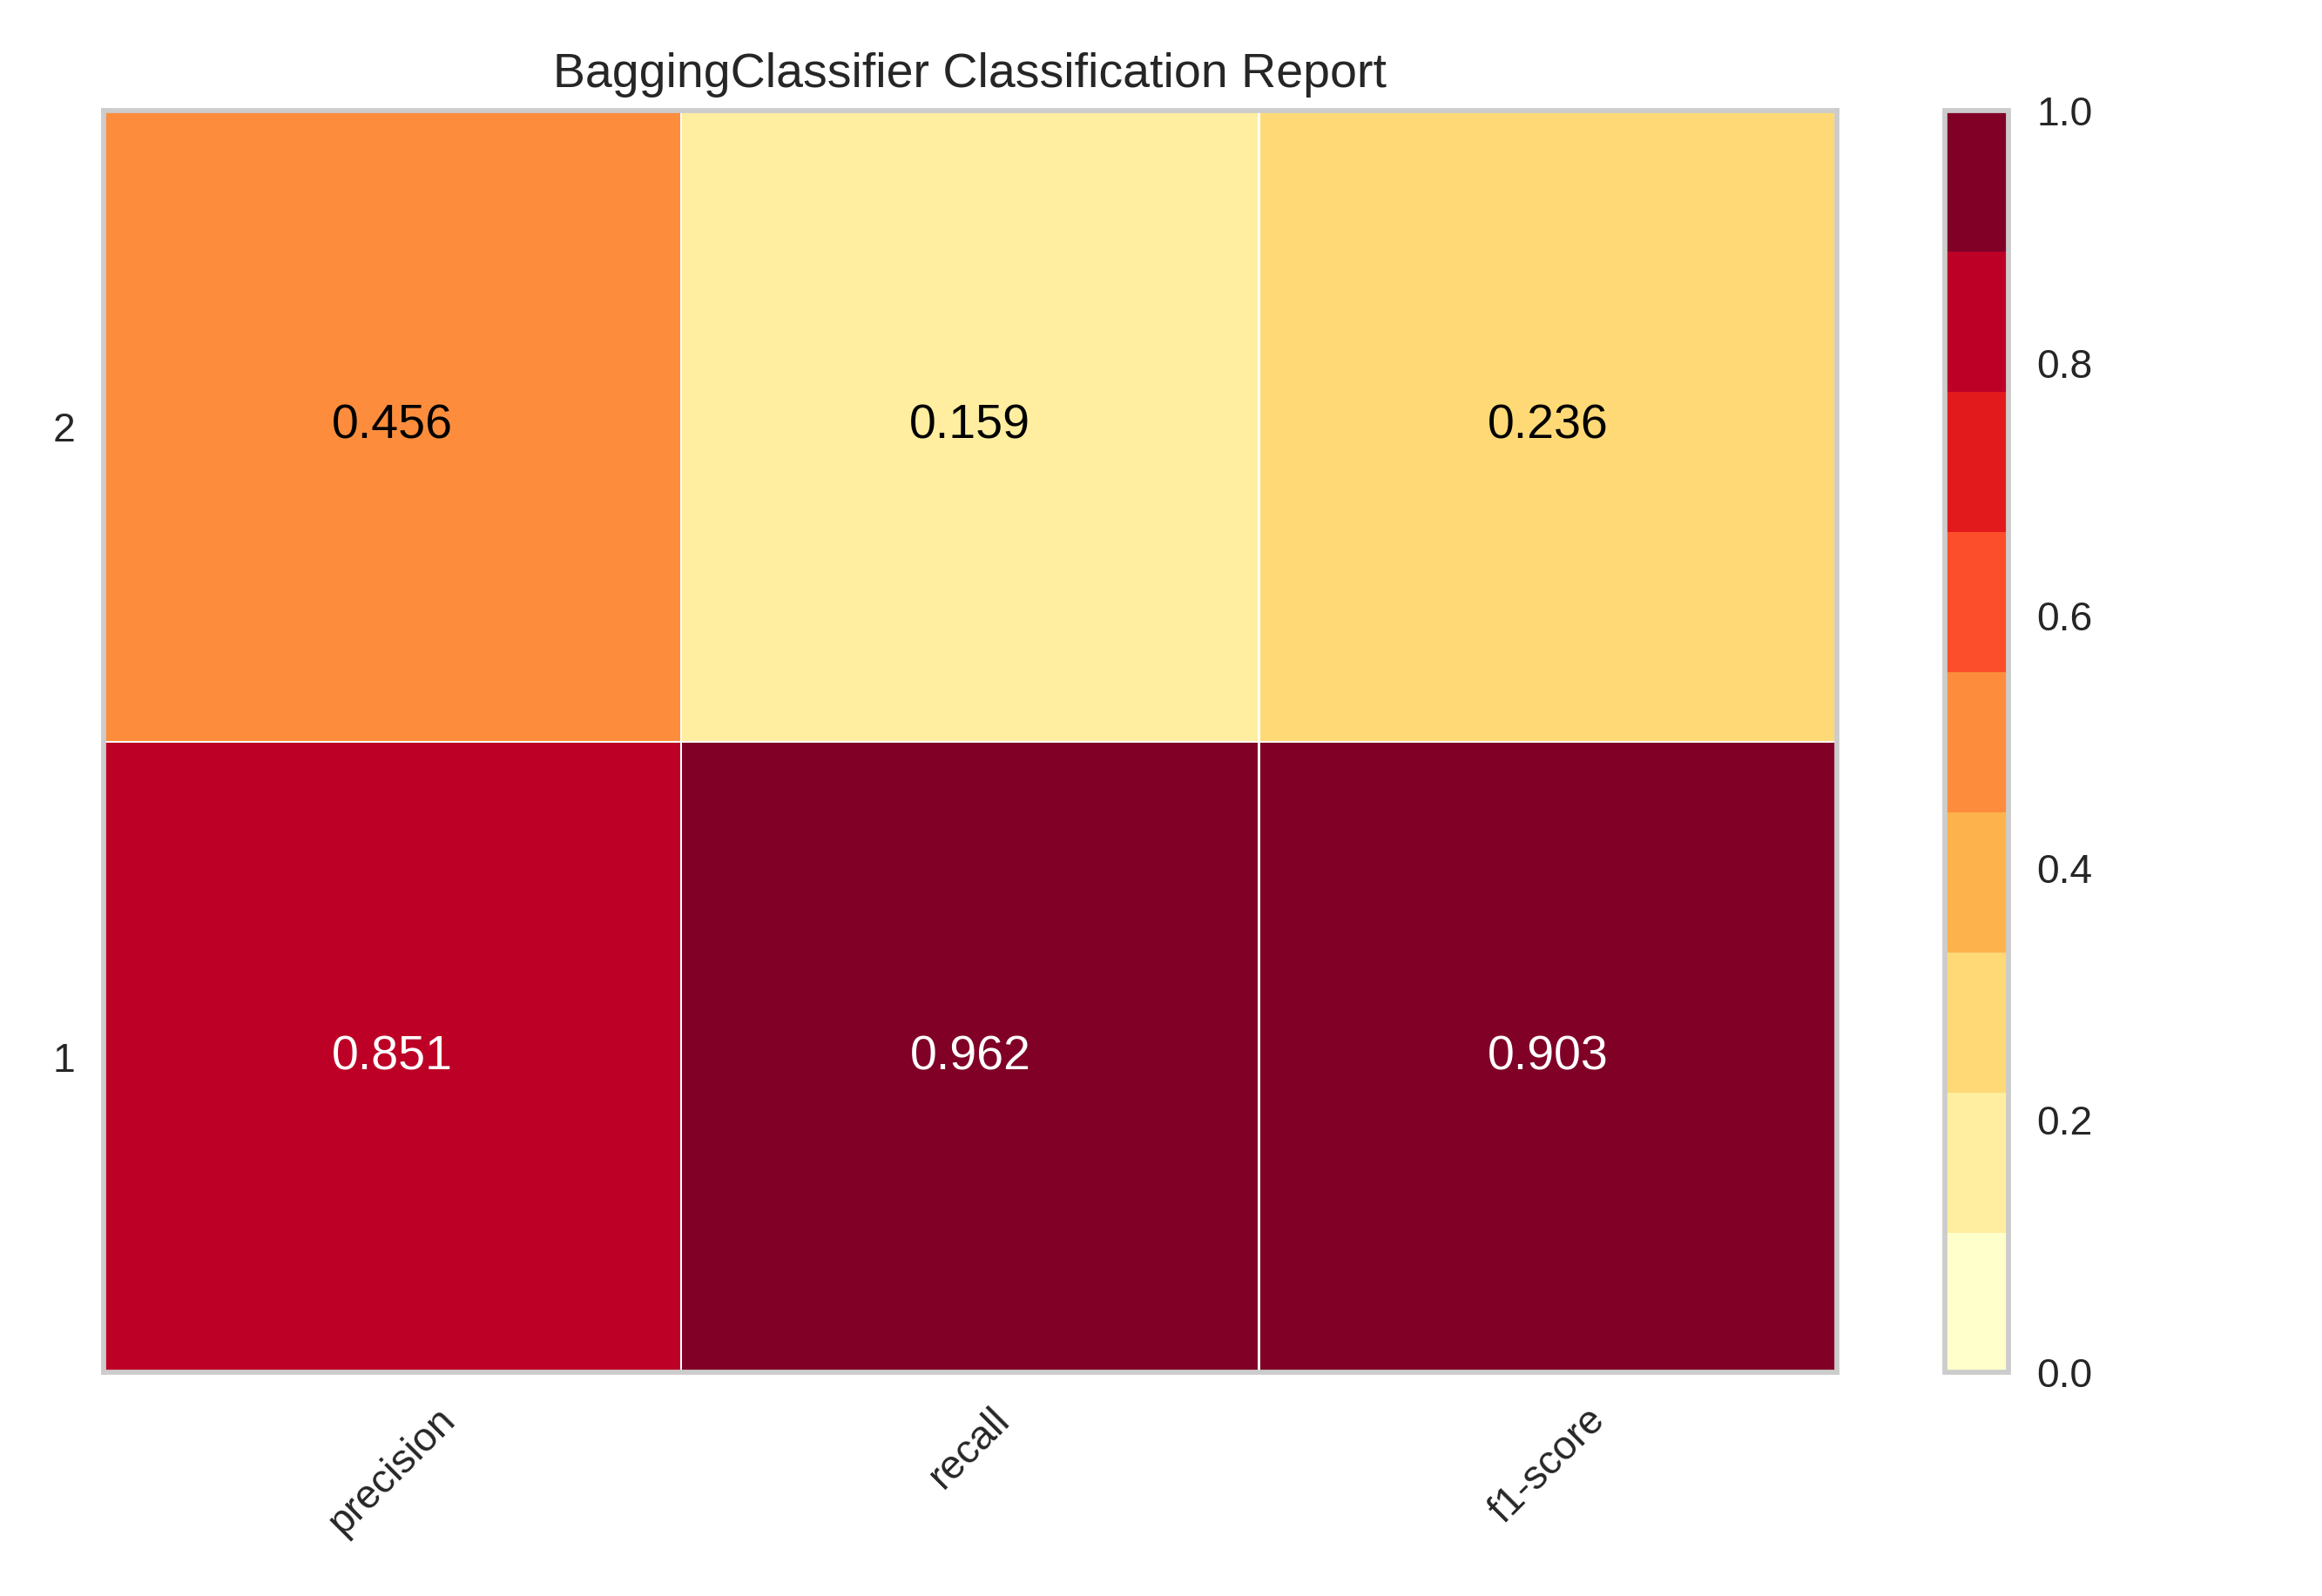

In [254]:
classifier_graph(BaggingClassifier())

<IPython.core.display.Javascript object>


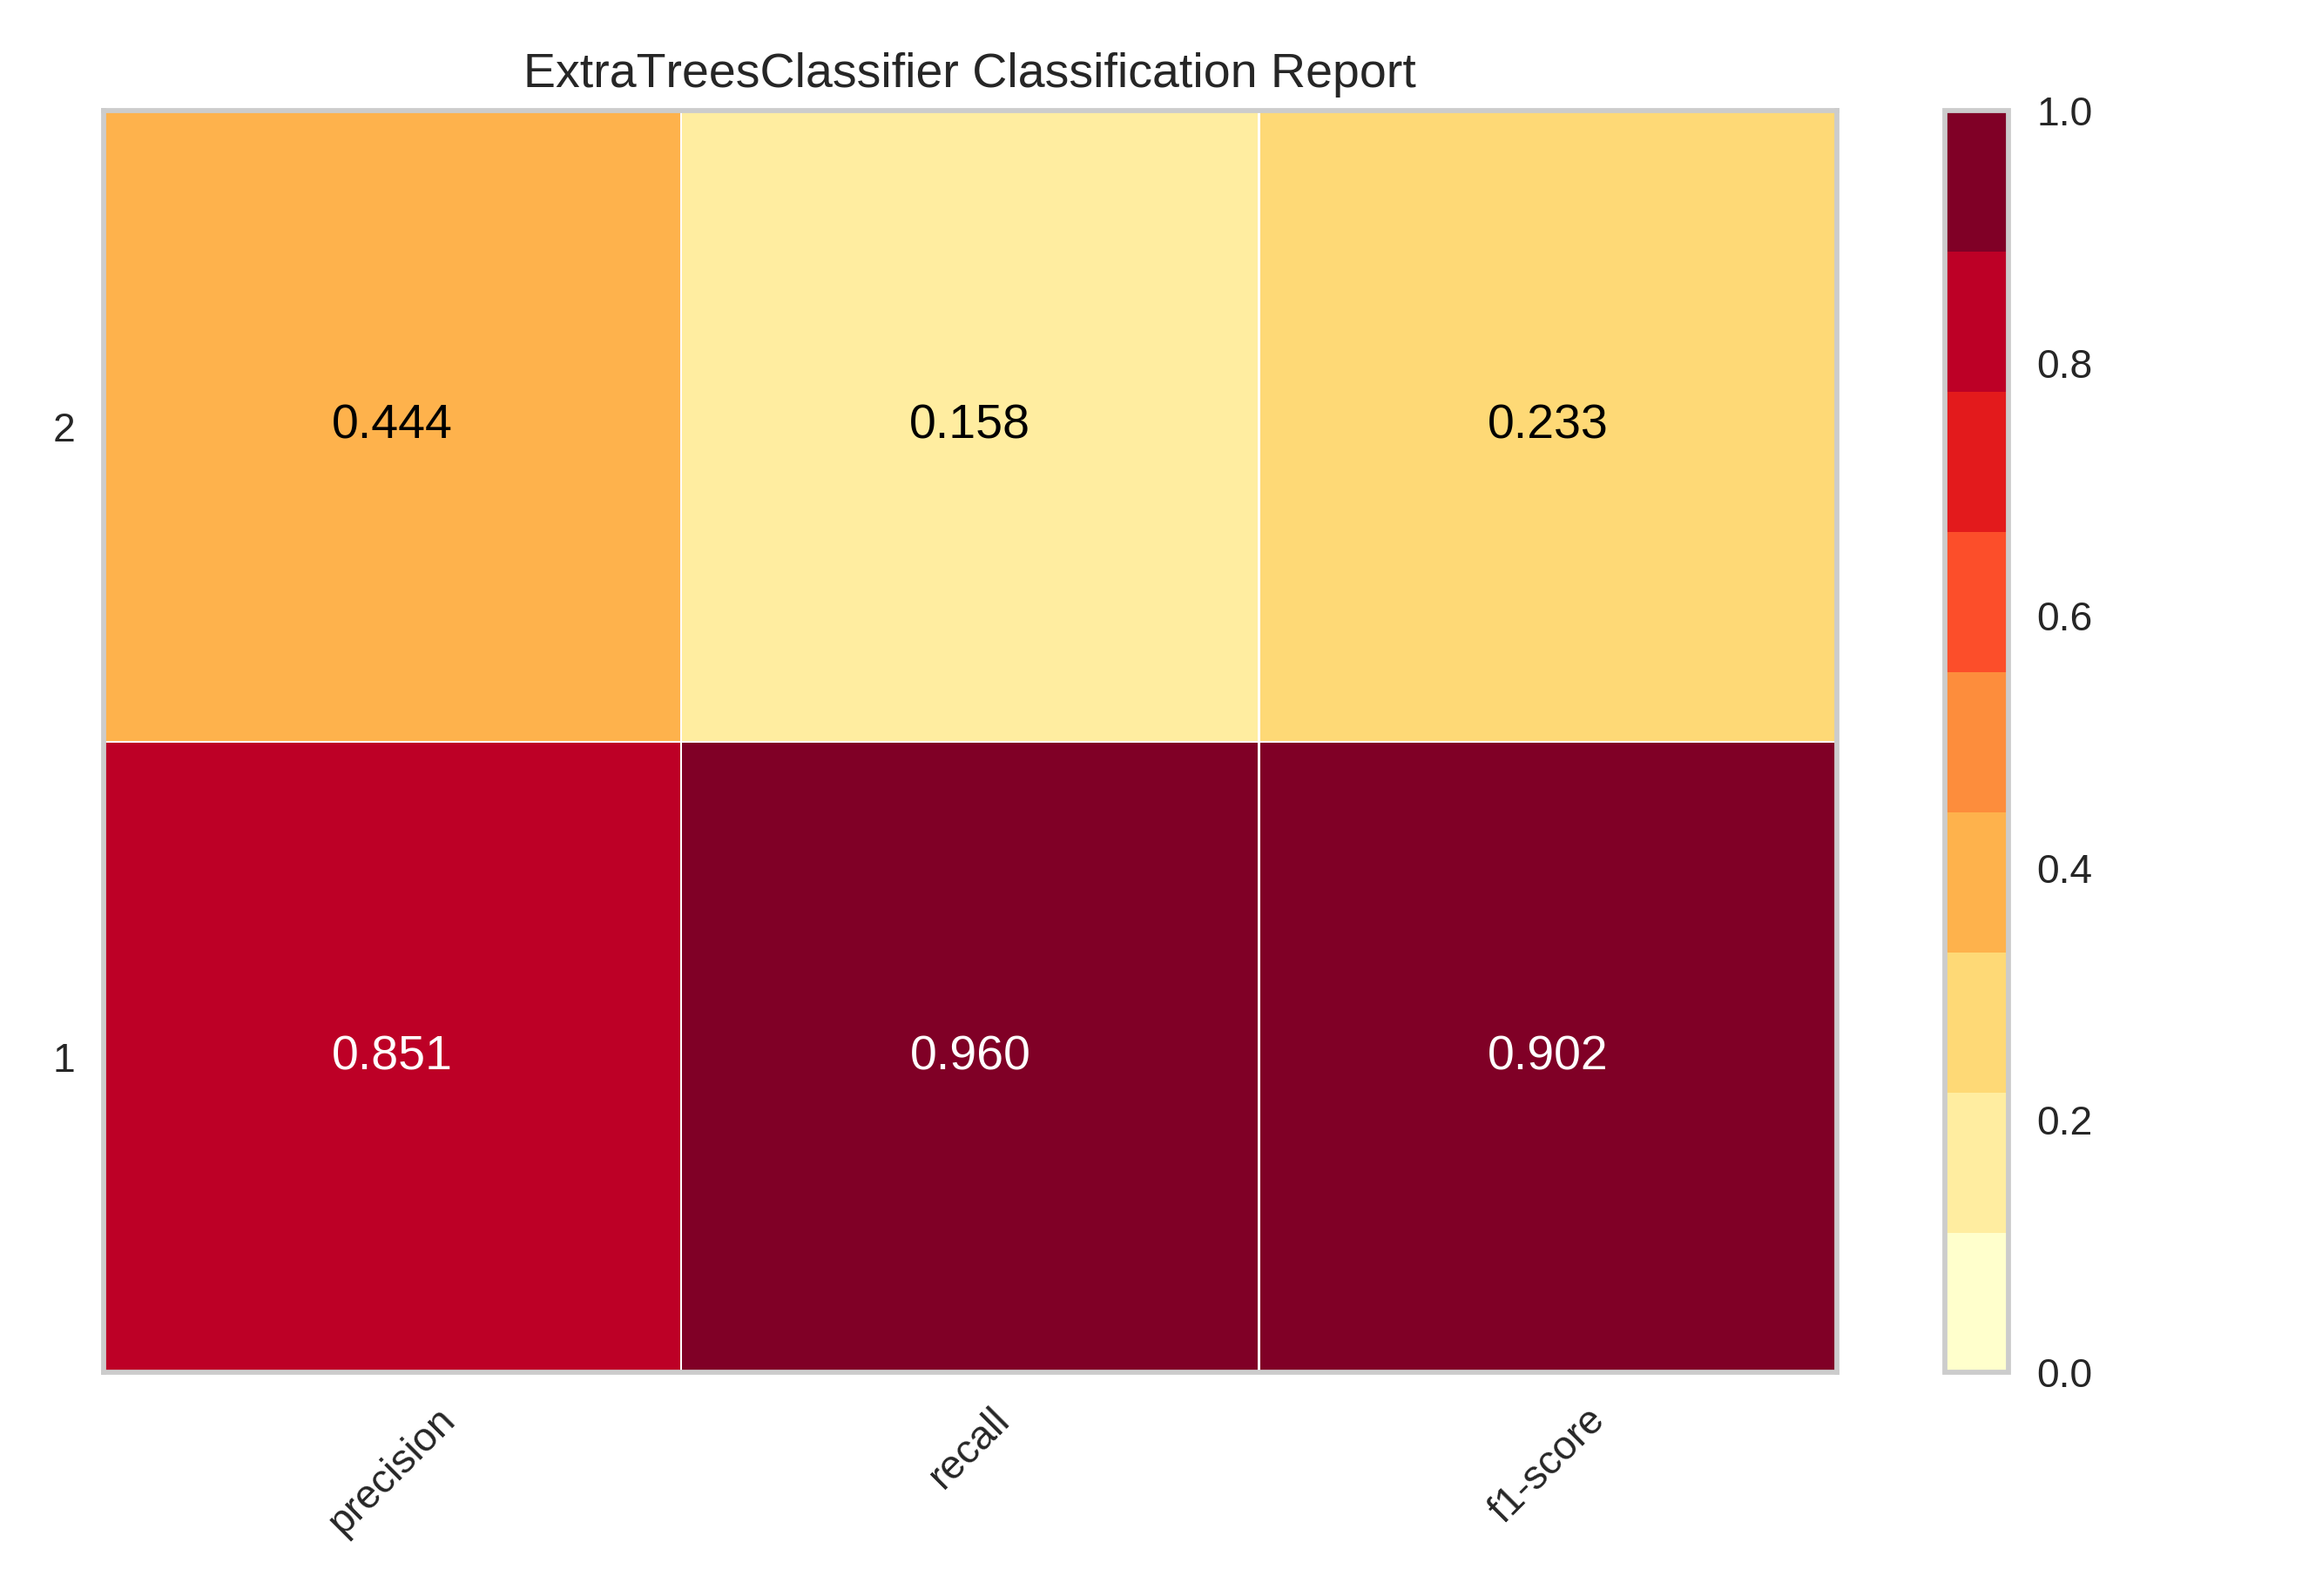

In [255]:
classifier_graph(ExtraTreesClassifier())

<IPython.core.display.Javascript object>


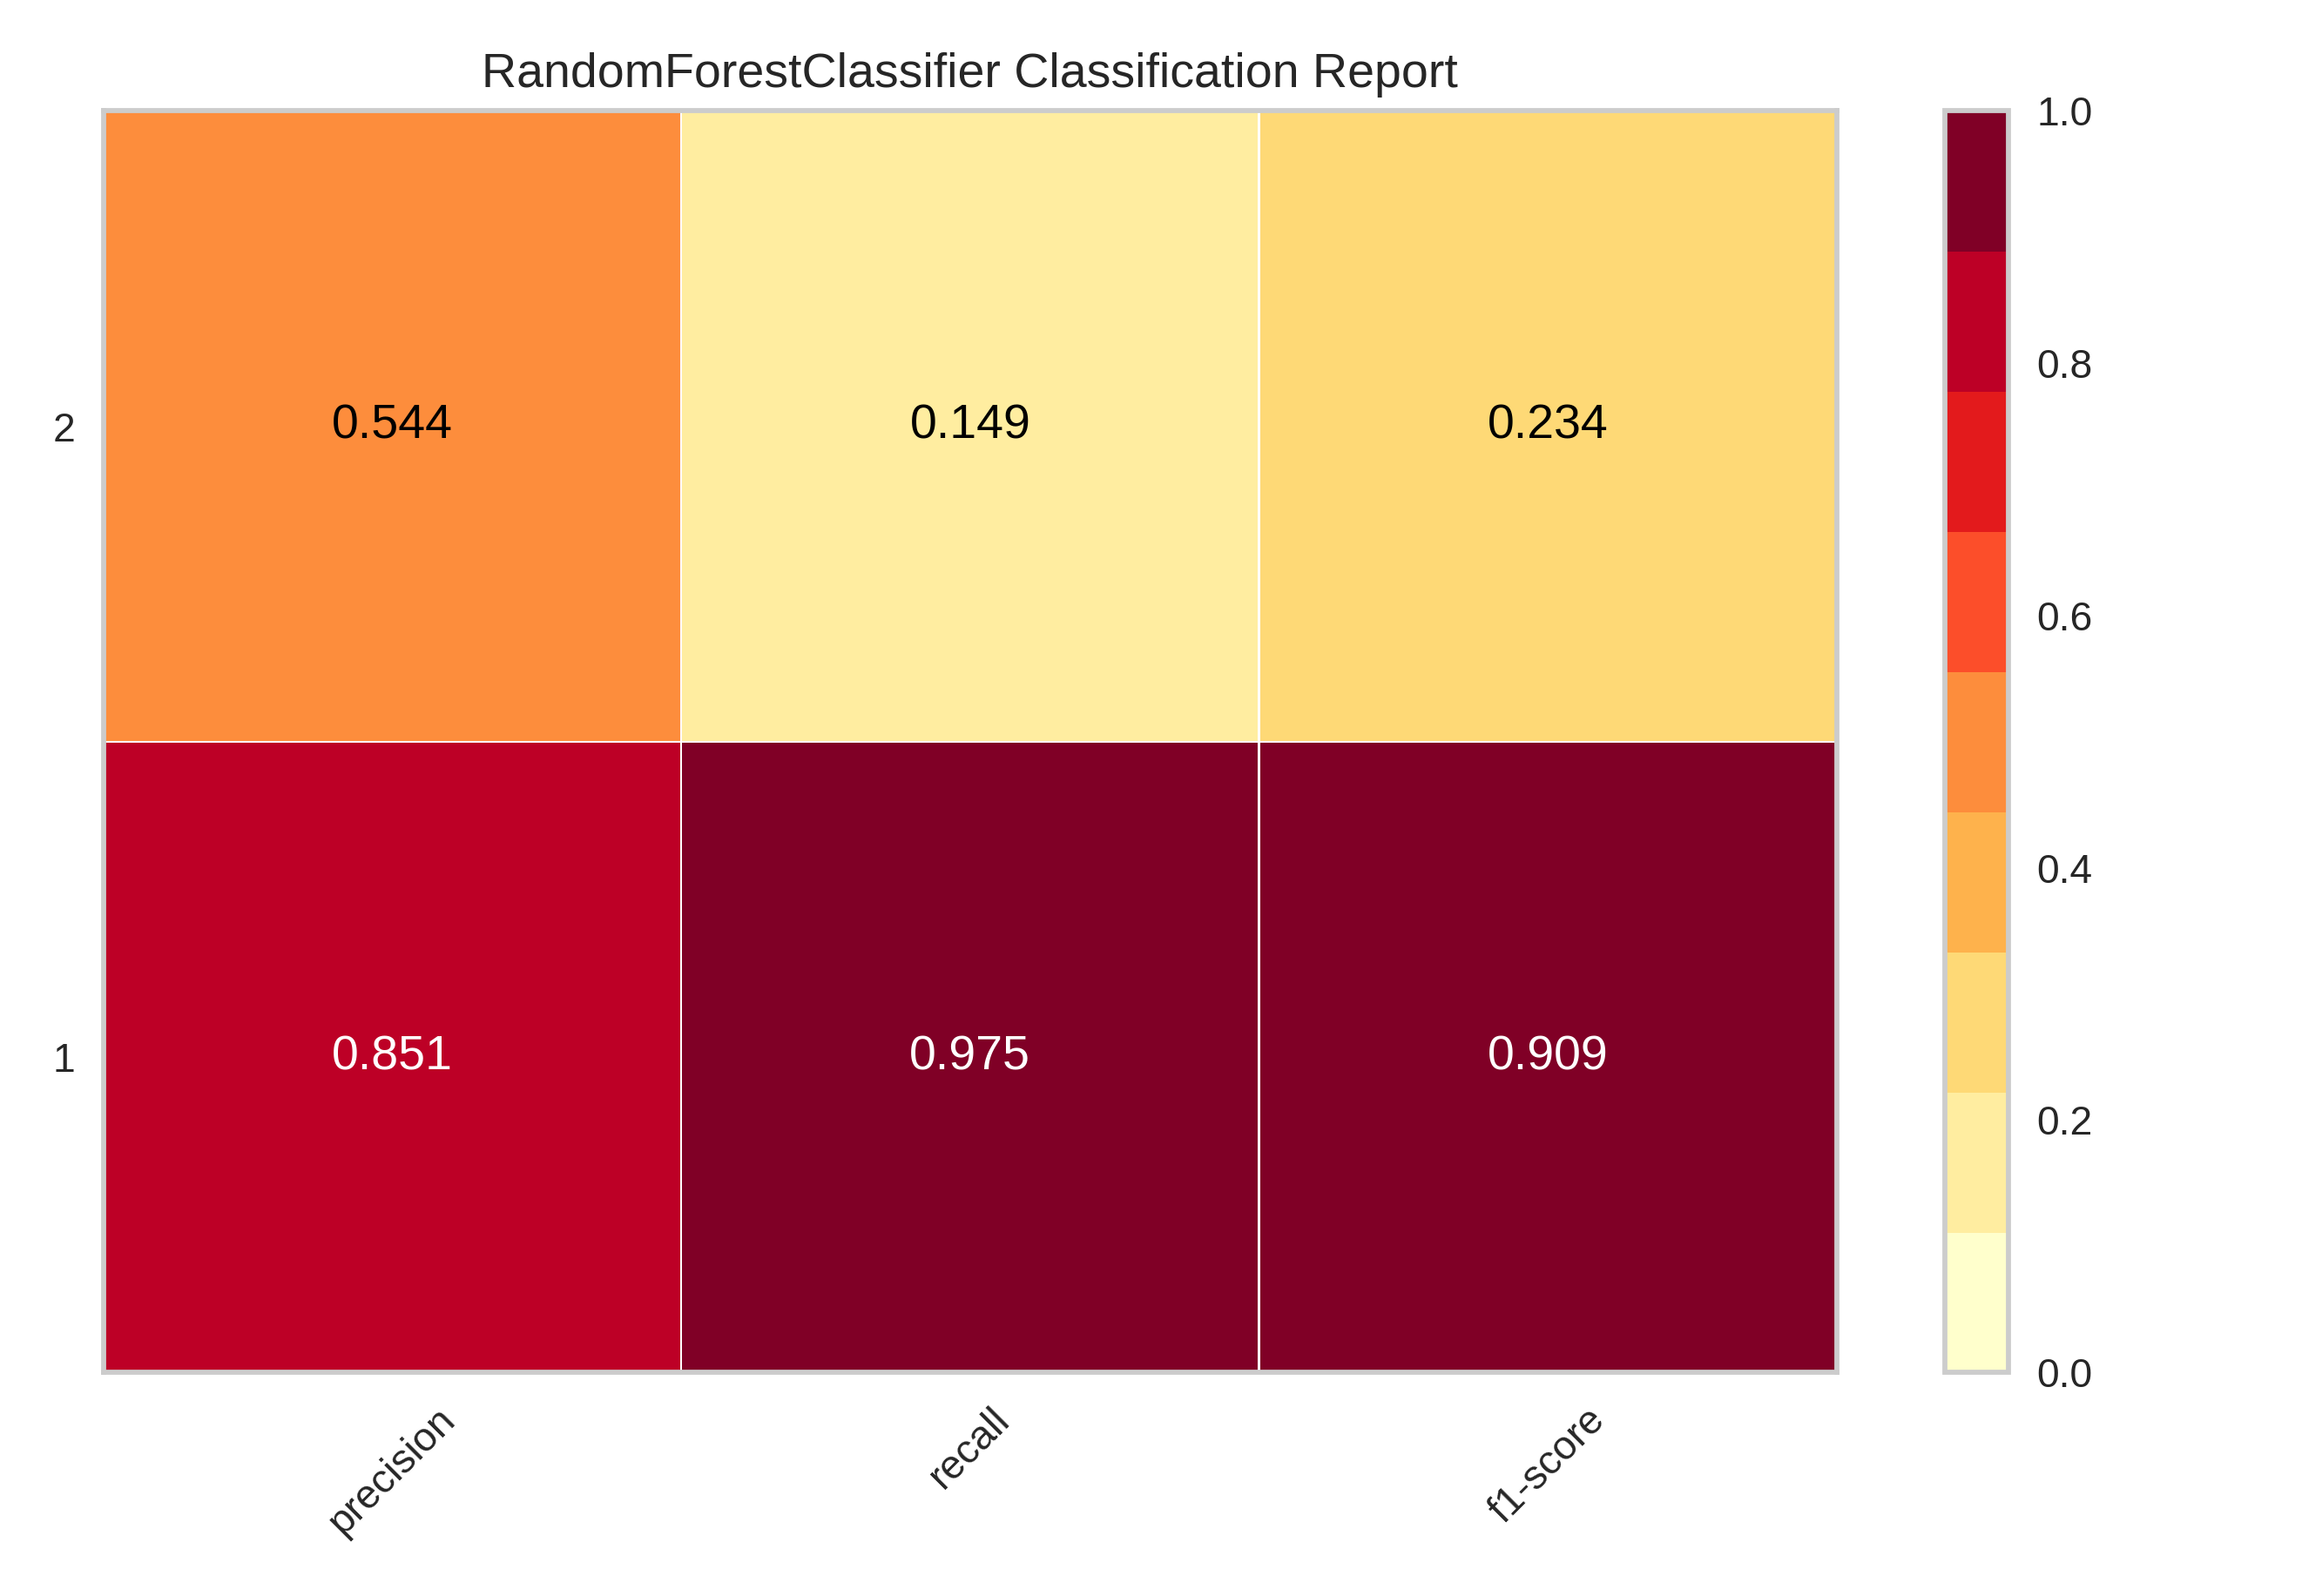

In [264]:
classifier_graph(RandomForestClassifier(n_estimators=300))



# ________________USING ANN__________
 

In [46]:
import keras
import tensorflow
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras.utils import np_utils

/home/franco/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [48]:
y = y.reshape(-1, 1)
onehotencoder = OneHotEncoder()
y = onehotencoder.fit_transform(y).toarray()
y = pd.DataFrame(y)


In [49]:
y.columns = ['1', '2']

In [50]:
y.head()

,1,2
0,0.0,1.0
1,0.0,1.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0


In [51]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2,random_state= 0)

In [52]:
X_train.shape

(222242, 36)

In [53]:
scaler = StandardScaler()
#scaler =  MinMaxScaler()
#scaler = Normalizer()
X_train = scaler.fit(X_train).transform(X_train)
X_test = scaler.fit(X_test).transform(X_test)

Finding the best learning rates:

In [101]:
from keras.optimizers import SGD

def ann_model(input_dim = 36):
    model = Sequential()
    model.add(Dense(units=100, input_dim=input_dim))
    model.add(Activation('relu'))
    model.add(Dense(units=100))
    model.add(Activation('relu'))
    model.add(Dense(units=100))
    model.add(Activation('relu'))
    model.add(Dense(units=100))
    model.add(Activation('relu'))
    model.add(Dense(units=2))
    model.add(Activation('softmax'))
    return(model)
learning_rate = [0.000001,0.01,1]

for lr in learning_rate:
    
    print('Testing for learning rate {}'.format(lr))
    model = ann_model()
    my_optimizer = SGD(lr = lr)
    model.compile(optimizer = my_optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'] )
    model.fit(X_train, y_train, batch_size = 500, epochs = 100)

Testing for learning rate 1e-06
Epoch 1/100
222242/222242 [==============================] - 2s 11us/step - loss: 0.7410 - acc: 0.2808
Epoch 2/100
222242/222242 [==============================] - 2s 9us/step - loss: 0.7402 - acc: 0.2835
Epoch 3/100
222242/222242 [==============================] - 2s 9us/step - loss: 0.7394 - acc: 0.2862
Epoch 4/100
222242/222242 [==============================] - 2s 9us/step - loss: 0.7385 - acc: 0.2889
Epoch 5/100
222242/222242 [==============================] - 2s 9us/step - loss: 0.7377 - acc: 0.2918
Epoch 6/100
222242/222242 [==============================] - 2s 9us/step - loss: 0.7369 - acc: 0.2949
Epoch 7/100
222242/222242 [==============================] - 2s 9us/step - loss: 0.7361 - acc: 0.2979
Epoch 8/100
222242/222242 [==============================] - 2s 9us/step - loss: 0.7352 - acc: 0.3006
Epoch 9/100
222242/222242 [==============================] - 2s 10us/step - loss: 0.7344 - acc: 0.3036
Epoch 10/100
222242/222242 [====================

222242/222242 [==============================] - 2s 8us/step - loss: 0.4012 - acc: 0.8326
Epoch 60/100
222242/222242 [==============================] - 2s 8us/step - loss: 0.4011 - acc: 0.8327
Epoch 61/100
222242/222242 [==============================] - 2s 8us/step - loss: 0.4011 - acc: 0.8326
Epoch 62/100
222242/222242 [==============================] - 2s 8us/step - loss: 0.4010 - acc: 0.8328
Epoch 63/100
222242/222242 [==============================] - 2s 8us/step - loss: 0.4009 - acc: 0.8327
Epoch 64/100
222242/222242 [==============================] - 2s 8us/step - loss: 0.4008 - acc: 0.8328
Epoch 65/100
222242/222242 [==============================] - 2s 8us/step - loss: 0.4007 - acc: 0.8327
Epoch 66/100
222242/222242 [==============================] - 2s 8us/step - loss: 0.4006 - acc: 0.8328
Epoch 67/100
222242/222242 [==============================] - 2s 8us/step - loss: 0.4005 - acc: 0.8329
Epoch 68/100
222242/222242 [==============================] - 2s 8us/step - loss: 0.40

def sequential_experiments(n_layers = 1, n_nodes = 100)

    if n_layers = 1 and n_nodes = 100:
        
        model = Sequential()

        model.add(Dense(units=250, input_dim=36))
        model.add(Activation('relu'))

        model.add(Dense(units=2))
        model.add(Activation('softmax'))

    
        model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
        model.fit(X_train, y_train, batch_size = 500, epochs = 100)
        return(model)
    
    if n_layers = 10 and n_nodes = 300:
        
        model = Sequential()
        
        model.add(Dense(units=250, input_dim=36))
        model.add(Activation('relu'))
        model.add(Dense(units=250, input_dim=36))
        model.add(Activation('relu'))
        model.add(Dense(units=250, input_dim=36))
        model.add(Activation('relu'))
        model.add(Dense(units=250, input_dim=36))
        model.add(Activation('relu'))
        model.add(Dense(units=250, input_dim=36))
        model.add(Activation('relu'))
        
        model.add(Dense(units=2))
        model.add(Activation('softmax'))

    
        model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
        model.fit(X_train, y_train, batch_size = 500, epochs = 100)
        return(model)
    
    
This function will be able to run many different combinations of nodes and layers, the idea is that when finds a model with the best score, it will save it to disk.

Try with adam optimizer:

In [54]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience = 3)

model = Sequential()

model.add(Dense(units=350, input_dim=36))
model.add(Activation('relu'))
model.add(Dense(units=350, input_dim=36))
model.add(Activation('relu'))
model.add(Dense(units=350, input_dim=36))
model.add(Activation('relu'))
model.add(Activation('relu'))
model.add(Dense(units=350, input_dim=36))
model.add(Activation('relu'))
model.add(Dense(units=350, input_dim=36))
model.add(Activation('relu'))
model.add(Activation('relu'))
model.add(Dense(units=350, input_dim=36))
model.add(Activation('relu'))
model.add(Dense(units=350, input_dim=36))
model.add(Activation('relu'))
model.add(Dense(units=2))
model.add(Activation('softmax'))

# 
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.fit(X_train, y_train, batch_size = 500, epochs = 1000)


Epoch 1/1000
222242/222242 [==============================] - 11s 50us/step - loss: 0.4120 - acc: 0.8294
Epoch 2/1000
222242/222242 [==============================] - 11s 50us/step - loss: 0.4057 - acc: 0.8304
Epoch 3/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.4032 - acc: 0.8319
Epoch 4/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.4013 - acc: 0.8325
Epoch 5/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.3994 - acc: 0.8332
Epoch 6/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.3976 - acc: 0.8339
Epoch 7/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.3962 - acc: 0.8342
Epoch 8/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.3946 - acc: 0.8350
Epoch 9/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.3928 - acc: 0.8354
Epoch 10/1000
222242/222242 [==========================

222242/222242 [==============================] - 11s 50us/step - loss: 0.0719 - acc: 0.9735
Epoch 79/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0705 - acc: 0.9737
Epoch 80/1000
222242/222242 [==============================] - 11s 50us/step - loss: 0.0693 - acc: 0.9745
Epoch 81/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0685 - acc: 0.9746
Epoch 82/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0683 - acc: 0.9748
Epoch 83/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0665 - acc: 0.9755
Epoch 84/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0649 - acc: 0.9763
Epoch 85/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0625 - acc: 0.9773
Epoch 86/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0637 - acc: 0.9764
Epoch 87/1000
222242/222242 [==============================]

222242/222242 [==============================] - 10s 46us/step - loss: 0.0315 - acc: 0.9891
Epoch 155/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0309 - acc: 0.9894
Epoch 156/1000
222242/222242 [==============================] - 10s 45us/step - loss: 0.0317 - acc: 0.9890
Epoch 157/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0322 - acc: 0.9889
Epoch 158/1000
222242/222242 [==============================] - 10s 45us/step - loss: 0.0300 - acc: 0.9898
Epoch 159/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0310 - acc: 0.9896
Epoch 160/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0296 - acc: 0.9897
Epoch 161/1000
222242/222242 [==============================] - 10s 45us/step - loss: 0.0296 - acc: 0.9898
Epoch 162/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0292 - acc: 0.9899
Epoch 163/1000
222242/222242 [======================

222242/222242 [==============================] - 10s 46us/step - loss: 0.0202 - acc: 0.9933
Epoch 231/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0204 - acc: 0.9932
Epoch 232/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0218 - acc: 0.9926
Epoch 233/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0219 - acc: 0.9929
Epoch 234/1000
222242/222242 [==============================] - 10s 45us/step - loss: 0.0189 - acc: 0.9938
Epoch 235/1000
222242/222242 [==============================] - 10s 45us/step - loss: 0.0207 - acc: 0.9932
Epoch 236/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0211 - acc: 0.9932
Epoch 237/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0202 - acc: 0.9934
Epoch 238/1000
222242/222242 [==============================] - 10s 45us/step - loss: 0.0201 - acc: 0.9935
Epoch 239/1000
222242/222242 [======================

222242/222242 [==============================] - 10s 46us/step - loss: 0.0154 - acc: 0.9952
Epoch 307/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0162 - acc: 0.9949
Epoch 308/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0171 - acc: 0.9946
Epoch 309/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0154 - acc: 0.9951
Epoch 310/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0156 - acc: 0.9951
Epoch 311/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0162 - acc: 0.9948
Epoch 312/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0146 - acc: 0.9954
Epoch 313/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0191 - acc: 0.9943
Epoch 314/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0174 - acc: 0.9946
Epoch 315/1000
222242/222242 [======================

222242/222242 [==============================] - 10s 46us/step - loss: 0.0134 - acc: 0.9959
Epoch 383/1000
222242/222242 [==============================] - 10s 45us/step - loss: 0.0145 - acc: 0.9956
Epoch 384/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0123 - acc: 0.9964
Epoch 385/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0159 - acc: 0.9951
Epoch 386/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0131 - acc: 0.9960
Epoch 387/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0142 - acc: 0.9958
Epoch 388/1000
222242/222242 [==============================] - 10s 45us/step - loss: 0.0118 - acc: 0.9965
Epoch 389/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0117 - acc: 0.9963
Epoch 390/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0127 - acc: 0.9962
Epoch 391/1000
222242/222242 [======================

222242/222242 [==============================] - 10s 46us/step - loss: 0.0111 - acc: 0.9969
Epoch 459/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0122 - acc: 0.9964
Epoch 460/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0119 - acc: 0.9963
Epoch 461/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0150 - acc: 0.9955
Epoch 462/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0108 - acc: 0.9967
Epoch 463/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0122 - acc: 0.9966
Epoch 464/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0117 - acc: 0.9967
Epoch 465/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0127 - acc: 0.9963
Epoch 466/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0202 - acc: 0.9940
Epoch 467/1000
222242/222242 [======================

222242/222242 [==============================] - 10s 46us/step - loss: 0.0173 - acc: 0.9954
Epoch 535/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0128 - acc: 0.9964
Epoch 536/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0102 - acc: 0.9973
Epoch 537/1000
222242/222242 [==============================] - 10s 47us/step - loss: 0.0106 - acc: 0.9970
Epoch 538/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0198 - acc: 0.9943
Epoch 539/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0114 - acc: 0.9967
Epoch 540/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0195 - acc: 0.9949
Epoch 541/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0131 - acc: 0.9964
Epoch 542/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0119 - acc: 0.9966
Epoch 543/1000
222242/222242 [======================

222242/222242 [==============================] - 10s 46us/step - loss: 0.0115 - acc: 0.9970
Epoch 611/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0100 - acc: 0.9974
Epoch 612/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0076 - acc: 0.9979
Epoch 613/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0123 - acc: 0.9965
Epoch 614/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0105 - acc: 0.9970
Epoch 615/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0099 - acc: 0.9973
Epoch 616/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0112 - acc: 0.9969
Epoch 617/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0093 - acc: 0.9977
Epoch 618/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0151 - acc: 0.9958
Epoch 619/1000
222242/222242 [======================

222242/222242 [==============================] - 10s 46us/step - loss: 0.0121 - acc: 0.9964
Epoch 687/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0099 - acc: 0.9973
Epoch 688/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0073 - acc: 0.9979
Epoch 689/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0097 - acc: 0.9974
Epoch 690/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0092 - acc: 0.9976
Epoch 691/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0084 - acc: 0.9978
Epoch 692/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0088 - acc: 0.9976
Epoch 693/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0133 - acc: 0.9964
Epoch 694/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0116 - acc: 0.9969
Epoch 695/1000
222242/222242 [======================

222242/222242 [==============================] - 10s 46us/step - loss: 0.0111 - acc: 0.9972
Epoch 763/1000
222242/222242 [==============================] - 10s 45us/step - loss: 0.0075 - acc: 0.9982
Epoch 764/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0063 - acc: 0.9984
Epoch 765/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0119 - acc: 0.9969
Epoch 766/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0094 - acc: 0.9976
Epoch 767/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0065 - acc: 0.9983
Epoch 768/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0086 - acc: 0.9978
Epoch 769/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0081 - acc: 0.9981
Epoch 770/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0087 - acc: 0.9979
Epoch 771/1000
222242/222242 [======================

222242/222242 [==============================] - 10s 46us/step - loss: 0.0079 - acc: 0.9978
Epoch 839/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0073 - acc: 0.9981
Epoch 840/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0124 - acc: 0.9969
Epoch 841/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0138 - acc: 0.9962
Epoch 842/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0084 - acc: 0.9980
Epoch 843/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0104 - acc: 0.9972
Epoch 844/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0076 - acc: 0.9980
Epoch 845/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0063 - acc: 0.9984
Epoch 846/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0123 - acc: 0.9967
Epoch 847/1000
222242/222242 [======================

222242/222242 [==============================] - 10s 46us/step - loss: 0.0092 - acc: 0.9977
Epoch 915/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0126 - acc: 0.9968
Epoch 916/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0087 - acc: 0.9979
Epoch 917/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0081 - acc: 0.9983
Epoch 918/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0115 - acc: 0.9974
Epoch 919/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0181 - acc: 0.9957
Epoch 920/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0091 - acc: 0.9980
Epoch 921/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0124 - acc: 0.9971
Epoch 922/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0131 - acc: 0.9967
Epoch 923/1000
222242/222242 [======================

222242/222242 [==============================] - 10s 46us/step - loss: 0.0141 - acc: 0.9967
Epoch 991/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0085 - acc: 0.9979
Epoch 992/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0204 - acc: 0.9953
Epoch 993/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0092 - acc: 0.9978
Epoch 994/1000
222242/222242 [==============================] - 10s 45us/step - loss: 0.0086 - acc: 0.9980
Epoch 995/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0158 - acc: 0.9959
Epoch 996/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0142 - acc: 0.9962
Epoch 997/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0089 - acc: 0.9979
Epoch 998/1000
222242/222242 [==============================] - 10s 46us/step - loss: 0.0092 - acc: 0.9977
Epoch 999/1000
222242/222242 [======================

In [55]:
y_predict = model.predict(X_test)
y_test = y_test.astype(float)
y_predict = y_predict
y_predict = y_predict >= 0.5

In [56]:
y_traindf = pd.DataFrame(y_train)

Creating confusion matrix:

In [57]:
from sklearn.metrics import confusion_matrix
from numpy import argmax
cf = confusion_matrix(y_test.values.argmax(axis=1), y_predict.argmax(axis=1))
from sklearn.metrics import accuracy_score
#accuracy = accuracy_score(y_test_white, y_predict)
cf

array([[41462,  4845],
       [ 7048,  2206]])

In [58]:
accuracy = classification_report(y_test, y_predict)

In [59]:
print(accuracy) # 0, violent, 1 non violent.. it changed my 1, 2 columns!!

             precision    recall  f1-score   support

          0       0.85      0.90      0.87     46307
          1       0.31      0.24      0.27      9254

avg / total       0.76      0.79      0.77     55561



Saving the model to disk:

In [60]:
from keras.models import load_model
model.save('ANN_trained_model_1.h5')

In [ ]:
ann_model = load_model('ANN_trained_model_1.h5')
y_predict = ann_model.predict(X_test)
y_test = y_test.astype(float)
y_predict = y_predict
y_predict = y_predict > 0.15

In [61]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience = 3)

model = Sequential()

model.add(Dense(units=350, input_dim=36))
model.add(Activation('relu'))
model.add(Dense(units=350, input_dim=36))
model.add(Activation('relu'))
model.add(Dense(units=350, input_dim=36))
model.add(Activation('relu'))

model.add(Dense(units=2))
model.add(Activation('softmax'))

# 
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.fit(X_train, y_train, batch_size = 50, epochs = 700)


Epoch 1/700
222242/222242 [==============================] - 16s 72us/step - loss: 0.4117 - acc: 0.8299
Epoch 2/700
222242/222242 [==============================] - 17s 77us/step - loss: 0.4061 - acc: 0.8309
Epoch 3/700
222242/222242 [==============================] - 16s 73us/step - loss: 0.4040 - acc: 0.8318
Epoch 4/700
222242/222242 [==============================] - 17s 77us/step - loss: 0.4021 - acc: 0.8326
Epoch 5/700
222242/222242 [==============================] - 16s 73us/step - loss: 0.4007 - acc: 0.8331
Epoch 6/700
222242/222242 [==============================] - 16s 72us/step - loss: 0.3994 - acc: 0.8332
Epoch 7/700
222242/222242 [==============================] - 16s 73us/step - loss: 0.3984 - acc: 0.8337
Epoch 8/700
222242/222242 [==============================] - 16s 73us/step - loss: 0.3972 - acc: 0.8346
Epoch 9/700
222242/222242 [==============================] - 16s 74us/step - loss: 0.3965 - acc: 0.8344
Epoch 10/700
222242/222242 [==============================] - 16

222242/222242 [==============================] - 15s 65us/step - loss: 0.3184 - acc: 0.8650
Epoch 80/700
222242/222242 [==============================] - 14s 65us/step - loss: 0.3178 - acc: 0.8661
Epoch 81/700
222242/222242 [==============================] - 15s 65us/step - loss: 0.3170 - acc: 0.8661
Epoch 82/700
222242/222242 [==============================] - 15s 65us/step - loss: 0.3155 - acc: 0.8670
Epoch 83/700
222242/222242 [==============================] - 15s 66us/step - loss: 0.3146 - acc: 0.8672
Epoch 84/700
222242/222242 [==============================] - 14s 65us/step - loss: 0.3137 - acc: 0.8677
Epoch 85/700
222242/222242 [==============================] - 14s 65us/step - loss: 0.3137 - acc: 0.8677
Epoch 86/700
222242/222242 [==============================] - 14s 65us/step - loss: 0.3133 - acc: 0.8679
Epoch 87/700
222242/222242 [==============================] - 15s 66us/step - loss: 0.3127 - acc: 0.8684
Epoch 88/700
222242/222242 [==============================] - 14s 65

222242/222242 [==============================] - 14s 65us/step - loss: 0.2768 - acc: 0.8814
Epoch 157/700
222242/222242 [==============================] - 15s 65us/step - loss: 0.2751 - acc: 0.8820
Epoch 158/700
222242/222242 [==============================] - 14s 65us/step - loss: 0.2748 - acc: 0.8820
Epoch 159/700
222242/222242 [==============================] - 15s 65us/step - loss: 0.2746 - acc: 0.8818
Epoch 160/700
222242/222242 [==============================] - 15s 65us/step - loss: 0.2739 - acc: 0.8821
Epoch 161/700
222242/222242 [==============================] - 15s 65us/step - loss: 0.2749 - acc: 0.8815
Epoch 162/700
222242/222242 [==============================] - 15s 65us/step - loss: 0.2743 - acc: 0.8821
Epoch 163/700
222242/222242 [==============================] - 15s 65us/step - loss: 0.2735 - acc: 0.8823
Epoch 164/700
222242/222242 [==============================] - 15s 65us/step - loss: 0.2735 - acc: 0.8823
Epoch 165/700
222242/222242 [==============================]

222242/222242 [==============================] - 14s 65us/step - loss: 0.2547 - acc: 0.8884
Epoch 234/700
222242/222242 [==============================] - 14s 65us/step - loss: 0.2557 - acc: 0.8881
Epoch 235/700
222242/222242 [==============================] - 14s 65us/step - loss: 0.2534 - acc: 0.8883
Epoch 236/700
222242/222242 [==============================] - 15s 65us/step - loss: 0.2548 - acc: 0.8881
Epoch 237/700
222242/222242 [==============================] - 14s 65us/step - loss: 0.2547 - acc: 0.8885
Epoch 238/700
222242/222242 [==============================] - 14s 65us/step - loss: 0.2552 - acc: 0.8885
Epoch 239/700
222242/222242 [==============================] - 15s 65us/step - loss: 0.2546 - acc: 0.8884
Epoch 240/700
222242/222242 [==============================] - 14s 65us/step - loss: 0.2545 - acc: 0.8883
Epoch 241/700
222242/222242 [==============================] - 15s 65us/step - loss: 0.2536 - acc: 0.8886
Epoch 242/700
222242/222242 [==============================]

222242/222242 [==============================] - 14s 65us/step - loss: 0.2460 - acc: 0.8912
Epoch 311/700
222242/222242 [==============================] - 14s 65us/step - loss: 0.2441 - acc: 0.8914
Epoch 312/700
222242/222242 [==============================] - 14s 65us/step - loss: 0.2452 - acc: 0.8915
Epoch 313/700
222242/222242 [==============================] - 14s 65us/step - loss: 0.2470 - acc: 0.8908
Epoch 314/700
222242/222242 [==============================] - 14s 65us/step - loss: 0.2416 - acc: 0.8924
Epoch 315/700
222242/222242 [==============================] - 14s 65us/step - loss: 0.2441 - acc: 0.8915
Epoch 316/700
222242/222242 [==============================] - 14s 65us/step - loss: 0.2440 - acc: 0.8916
Epoch 317/700
222242/222242 [==============================] - 15s 65us/step - loss: 0.2437 - acc: 0.8918
Epoch 318/700
222242/222242 [==============================] - 15s 65us/step - loss: 0.2469 - acc: 0.8911
Epoch 319/700
222242/222242 [==============================]

222242/222242 [==============================] - 15s 65us/step - loss: 0.2380 - acc: 0.8932
Epoch 388/700
222242/222242 [==============================] - 15s 66us/step - loss: 0.2365 - acc: 0.8938
Epoch 389/700
222242/222242 [==============================] - 15s 65us/step - loss: 0.2385 - acc: 0.8931
Epoch 390/700
222242/222242 [==============================] - 14s 65us/step - loss: 0.2363 - acc: 0.8934
Epoch 391/700
222242/222242 [==============================] - 15s 65us/step - loss: 0.2383 - acc: 0.8934
Epoch 392/700
222242/222242 [==============================] - 15s 65us/step - loss: 0.2369 - acc: 0.8935
Epoch 393/700
222242/222242 [==============================] - 15s 65us/step - loss: 0.2392 - acc: 0.8936
Epoch 394/700
222242/222242 [==============================] - 14s 65us/step - loss: 0.2391 - acc: 0.8932
Epoch 395/700
222242/222242 [==============================] - 14s 65us/step - loss: 0.2387 - acc: 0.8929
Epoch 396/700
222242/222242 [==============================]

222242/222242 [==============================] - 15s 65us/step - loss: 0.2327 - acc: 0.8947
Epoch 465/700
222242/222242 [==============================] - 14s 65us/step - loss: 0.2364 - acc: 0.8936
Epoch 466/700
222242/222242 [==============================] - 15s 65us/step - loss: 0.2343 - acc: 0.8947
Epoch 467/700
222242/222242 [==============================] - 15s 65us/step - loss: 0.2326 - acc: 0.8946
Epoch 468/700
222242/222242 [==============================] - 14s 65us/step - loss: 0.2349 - acc: 0.8942
Epoch 469/700
222242/222242 [==============================] - 14s 65us/step - loss: 0.2328 - acc: 0.8944
Epoch 470/700
222242/222242 [==============================] - 15s 65us/step - loss: 0.2367 - acc: 0.8935
Epoch 471/700
222242/222242 [==============================] - 15s 65us/step - loss: 0.2354 - acc: 0.8935
Epoch 472/700
222242/222242 [==============================] - 15s 65us/step - loss: 0.2316 - acc: 0.8948
Epoch 473/700
222242/222242 [==============================]

222242/222242 [==============================] - 14s 65us/step - loss: 0.2337 - acc: 0.8948
Epoch 542/700
222242/222242 [==============================] - 14s 65us/step - loss: 0.2334 - acc: 0.8945
Epoch 543/700
222242/222242 [==============================] - 14s 65us/step - loss: 0.2313 - acc: 0.8949
Epoch 544/700
222242/222242 [==============================] - 15s 65us/step - loss: 0.2345 - acc: 0.8946
Epoch 545/700
222242/222242 [==============================] - 14s 65us/step - loss: 0.2342 - acc: 0.8944
Epoch 546/700
222242/222242 [==============================] - 15s 65us/step - loss: 0.2340 - acc: 0.8945
Epoch 547/700
222242/222242 [==============================] - 15s 65us/step - loss: 0.2321 - acc: 0.8948
Epoch 548/700
222242/222242 [==============================] - 15s 65us/step - loss: 0.2341 - acc: 0.8944
Epoch 549/700
222242/222242 [==============================] - 15s 65us/step - loss: 0.2358 - acc: 0.8944
Epoch 550/700
222242/222242 [==============================]

222242/222242 [==============================] - 15s 65us/step - loss: 0.2376 - acc: 0.8936
Epoch 619/700
222242/222242 [==============================] - 15s 66us/step - loss: 0.2311 - acc: 0.8944
Epoch 620/700
222242/222242 [==============================] - 15s 65us/step - loss: 0.2331 - acc: 0.8942
Epoch 621/700
222242/222242 [==============================] - 15s 65us/step - loss: 0.2368 - acc: 0.8936
Epoch 622/700
222242/222242 [==============================] - 14s 65us/step - loss: 0.2327 - acc: 0.8949
Epoch 623/700
222242/222242 [==============================] - 14s 65us/step - loss: 0.2369 - acc: 0.8938
Epoch 624/700
222242/222242 [==============================] - 14s 65us/step - loss: 0.2416 - acc: 0.8925
Epoch 625/700
222242/222242 [==============================] - 14s 65us/step - loss: 0.2323 - acc: 0.8944
Epoch 626/700
222242/222242 [==============================] - 15s 65us/step - loss: 0.2347 - acc: 0.8946
Epoch 627/700
222242/222242 [==============================]

222242/222242 [==============================] - 15s 67us/step - loss: 0.2379 - acc: 0.8933
Epoch 696/700
222242/222242 [==============================] - 15s 67us/step - loss: 0.2388 - acc: 0.8934
Epoch 697/700
222242/222242 [==============================] - 15s 67us/step - loss: 0.2366 - acc: 0.8937
Epoch 698/700
222242/222242 [==============================] - 15s 67us/step - loss: 0.2334 - acc: 0.8941
Epoch 699/700
222242/222242 [==============================] - 15s 68us/step - loss: 0.2345 - acc: 0.8941
Epoch 700/700
222242/222242 [==============================] - 15s 67us/step - loss: 0.2322 - acc: 0.8945


In [65]:
from keras.models import load_model
model.save('ANN_trained_model_2.h5')

In [75]:
ann_model = load_model('ANN_trained_model_2.h5')
y_predict = ann_model.predict(X_test)
y_test = y_test.astype(float)
y_predict = y_predict
y_predict = y_predict > 0.50

In [76]:
from sklearn.metrics import confusion_matrix
from numpy import argmax
cf = confusion_matrix(y_test.values.argmax(axis=1), y_predict.argmax(axis=1))
from sklearn.metrics import accuracy_score
#accuracy = accuracy_score(y_test_white, y_predict)
cf

array([[43659,  2648],
       [ 7645,  1609]])

In [77]:
accuracy = classification_report(y_test, y_predict)

In [78]:
print(accuracy) # 0, violent, 1 non violent.. it changed my 1, 2 columns!!

             precision    recall  f1-score   support

          0       0.85      0.94      0.89     46307
          1       0.38      0.17      0.24      9254

avg / total       0.77      0.81      0.79     55561



Next Steps:
1. Choosing best models and using kfold cross validation for train and test sets.
   Also check features that may introduce leakage (sunday).
   
2. Hyperparameter tunning and dimensionality reduction. (sunday)
3. Try with 50 top restaurant locations.
4. Creation of API using flask and a self updating database (psycopg2) with the same columns than our wrangled csv file. (monday-friday)
4. Create more visualization (next-week)
5. Write the paper. (next-week)

5. heat map with clusters from restarurant adresses.

In [ ]:
# Choose and tune model...
# how do we add more weights to the poor performing class so it can perform better?.
# we expect the model to improve. with more user and police data entries, since most of the crimes are not reported.
# add an update model.

# DBSCAN clustering.

In [ ]:
new_data = {'block': 'xxxx', 'location': 'xxxxxx'}
new_data = pd.DataFrame(new_data)
new_data = new_data.values()

model.predict(new_data)